# Preparing the environment


## Libraries

In [1]:
# requirements
import pandas as pd
import scripts.eta_analysis as eta
import scripts.ra_analysis as ra
import numpy as np
import plotly.graph_objects as go

# Evaluation

In [2]:
def detect_anomaly_events(df, anomaly_col="has_anomaly"):
    events = []
    anomaly = df[anomaly_col].values

    in_event = False
    start_idx = None

    for i in range(len(anomaly)):

        if anomaly[i] == 1 and not in_event:
            start_idx = i
            in_event = True

        elif anomaly[i] == 0 and in_event:
            end_idx = i - 1
            events.append((start_idx, end_idx))
            in_event = False

    if in_event:
        events.append((start_idx, len(anomaly) - 1))

    return events

def compute_event_metrics(df, start_idx, end_idx, Ra_col="Ra"):
    Ra = df[Ra_col].values
    eta = df["eta"].values if "eta" in df.columns else None
    time = df["window_start"].values

    event_slice = slice(start_idx, end_idx + 1)

    Ra_event = Ra[event_slice]

    # --- Amplitude (max drop)
    peak_drop = 1 - Ra_event.min()

    # --- Response energy
    response_energy = np.sum(1 - Ra_event)

    # --- Detection delay
    threshold = 0.99

    detection_delay = None

    for i in range(start_idx, end_idx + 1):

        if Ra[i] < threshold:

            detection_delay = time[i] - time[start_idx]
            break

    # --- Recovery time
    recovery_time = None

    for i in range(end_idx + 1, len(Ra)):

        if Ra[i] >= threshold:

            recovery_time = time[i] - time[end_idx]
            break

    # --- Duration
    duration = time[end_idx] - time[start_idx]

    # --- Magnitude proxy
    if eta is not None:
        magnitude = eta[event_slice].mean()
    else:
        magnitude = np.nan

    # --- Pre-event baseline
    pre_Ra = Ra[start_idx - 1] if start_idx > 0 else Ra[start_idx]

    # --- Post-event state
    post_Ra = Ra[end_idx]

    return {
        "start_time": time[start_idx],
        "end_time": time[end_idx],
        "duration": duration,
        "peak_drop": peak_drop,
        "response_energy": response_energy,
        "detection_delay": detection_delay,
        "recovery_time": recovery_time,
        "magnitude": magnitude,
        "pre_event_Ra": pre_Ra,
        "post_event_Ra": post_Ra
    }

def analyze_endpoint_events(df_endpoint):
    events = detect_anomaly_events(df_endpoint)
    metrics = []
    for start_idx, end_idx in events:
        event_metrics = compute_event_metrics(
            df_endpoint,
            start_idx,
            end_idx
        )
        metrics.append(event_metrics)
    return metrics


def analyze_all_events(results_df):
    all_metrics = []
    grouped = results_df.groupby(["endpoint", "model"])
    for (endpoint, model), df_group in grouped:
        df_group = df_group.sort_values("window_start").reset_index(drop=True)
        event_metrics = analyze_endpoint_events(df_group)
        for m in event_metrics:
            m["endpoint"] = endpoint
            m["model"] = model
            all_metrics.append(m)
    return pd.DataFrame(all_metrics)


In [90]:
def define_plot_limits(df, time_col):
    anomaly_col = 'has_anomaly'
    df["start_flag"] = (
        (df[anomaly_col] == 1) &
        (df[anomaly_col].shift(1, fill_value=0) == 0)
    )

    df["event_id"] = df["start_flag"].cumsum()
    anomaly_windows = df[df[anomaly_col] == 1]
    durations = anomaly_windows.groupby("event_id").size()

    max_event_id = durations.idxmax()
    max_duration = durations.loc[max_event_id]
    event = anomaly_windows[anomaly_windows["event_id"] == max_event_id]
    start_time = event[time_col].iloc[0]

    #first_anomaly = df.loc[df['has_anomaly'] == 1, time_col].min()
    begin_plot = start_time - pd.Timedelta(minutes=10)
    end_plot = start_time + pd.Timedelta(minutes=30)
    print(f'greatest anomaly at:{start_time} - begin plot:{begin_plot} - end plot:{end_plot}')
    return begin_plot, end_plot

def normalize_traffic_flow(df):
    flow_log = np.log10(df['total_requests'] + 1)
    flow_scaled = (
        (flow_log - flow_log.min())/
        (flow_log.max() - flow_log.min() + 1e-9)
    )
    return flow_scaled

def plot_Ra(df, time_col, fig):
    color_map = {'Benign': 'green', 'Attack': 'red'}
    symbol_map = {
        'kalman':'square'
    }

    for model in df['model'].unique():
        md_df = df[df['model'] == model].copy()
        fig.add_trace(go.Scatter(
            x=md_df[time_col],
            y=md_df['Ra'],
            mode='markers',
            marker=dict(
                symbol=symbol_map[model],
                color=md_df['has_anomaly'].map(color_map),
                size=7,
                line=dict(width=0.5, color='black')
            ),
            name=f'Ra - {model} (colored by Attack/Benign)',
            hovertemplate='<br>Time: %{x}<br>Ra: %{y:.3f}<br>Status: %{marker.color}<extra></extra>')
        )

def plot_metrics(df, time_col, fig):
    metric_colors = {
        #'D': '#1f77b4',
        #'Z': '#ff7f0e',
        #'Delta': '#2ca02c',
        'eta': "#fde861",
        #'Ra2': "#fd61bc",
        #'C2': "#ff0000",
        'fDp': "#ff00ff",
        'fDeltap': "#ffc300",
        'fZp': "#bbff00"
    }

    for metric, color in metric_colors.items():
        fig.add_trace(go.Scatter(
            x=df[time_col],
            y=df[metric],
            mode='lines',
            line=dict(color=color, width=2),
            name=metric
        ))

def plot_traffic(df, time_col, fig):
    flow_scaled = normalize_traffic_flow(df)
    fig.add_trace(go.Scatter(
        x=df[time_col],
        y=flow_scaled,
        mode='lines',
        name='Flow by time',
        line=dict(color='#00c3ff'),
        hovertemplate='Time: %{x}<br>Request: %{y:.3f}<extra></extra>')
    )

def plot_results(plot_examples, res_df,df):
    unique_pairs = res_df['endpoint'].drop_duplicates().sample(min(plot_examples, len(res_df)))

    for endpoint in unique_pairs:
        time_col = 'window_start'
        sub_res = res_df[(res_df['endpoint'] == endpoint)].sort_values(time_col).copy()
        df_flow = df[(df['endpoint'] == endpoint)].sort_values('time_local').copy()

        begin_plot, end_plot = define_plot_limits(sub_res, time_col)

        sub_res = sub_res[(sub_res[time_col] >= begin_plot) & (sub_res[time_col] <= end_plot)].copy()
        sub_res[time_col] = sub_res[time_col] + pd.Timedelta(seconds=30)
        sub_res['has_anomaly'] = sub_res['has_anomaly'].map({1: 'Attack', 0: 'Benign'})

        df_flow = df_flow[(df_flow['time_local'] >= begin_plot) & (df_flow['time_local'] <= end_plot)].copy()

        fig = go.Figure()
        plot_metrics(sub_res, time_col, fig)
        plot_traffic(df_flow, 'time_local', fig)
        plot_Ra(sub_res, time_col, fig)

        # --- Layout ---
        fig.update_layout(
            title=f'Metrics evolution for the {endpoint}',
            xaxis_title='Time',
            yaxis_title='Metric value',
            template='plotly_white',
            legend_title_text='Metric',
            margin=dict(l=50, r=30, t=60, b=40)
        )

        fig.show()

In [4]:
def plot_sensibility(df_metris, x_var, y_var):
    df_metris = df_metris.sort_values(x_var)
    plt.figure(figsize=(10,5))
    sns.lineplot(
        data=df_metris,
        x=x_var,
        y=y_var,
        hue="endpoint",
        marker="o",
        linewidth=1.5,
        #palette="tab20"
    )

    plt.title(f"{y_var} vs {x_var} per Endpoint")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    #plt.ylim(0, 1.05)

    plt.legend(
        title="Endpoint",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
def build_correlation_table(event_metrics_df):
    metrics = []

    for model in event_metrics_df["window_size"].unique():

        df_model = event_metrics_df[event_metrics_df["window_size"] == model]

        if len(df_model) < 5:
            continue

        corr_mag_peak = df_model[["magnitude", "peak_drop"]].corr(method="spearman").iloc[0,1]
        corr_dur_energy = df_model[["duration", "response_energy"]].corr(method="spearman").iloc[0,1]
        corr_mag_energy = df_model[["magnitude", "response_energy"]].corr(method="spearman").iloc[0,1]
        corr_mag_delay = df_model[["magnitude", "detection_delay"]].corr(method="spearman").iloc[0,1]

        metrics.append({
            "model": model,
            "mag_vs_peak": corr_mag_peak,
            "dur_vs_energy": corr_dur_energy,
            "mag_vs_energy": corr_mag_energy,
            "mag_vs_delay": corr_mag_delay
        })

    corr_df = pd.DataFrame(metrics).set_index("model")

    return corr_df


Performance Metrics

In [6]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    confusion_matrix
)

def evaluate_performance(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='binary',
        zero_division=0
    )
    roc = roc_auc_score(y_true, y_score) if len(np.unique(y_true))>1 else float('nan')
    tn, fp, fn, tp = (confusion_matrix(y_true, y_pred, labels=[0,1])
                      .ravel())
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)

    return accuracy, precision, recall, f1, roc, tpr, fpr

def evaluate_ra_metrics(res_df, max_binary_threshold):
    global y_pred
    results = []

    grouped = res_df.groupby(["endpoint", "model", "window_size", "beta"])
    for (endpoint, model, window_size, beta), df_group in grouped:
        sub = df_group.sort_values("window_start").reset_index(drop=True)

        if sub is None or len(sub)==0:
            print('No results to evaluate.')
            break

        y_true = sub['has_anomaly'].astype(int).values
        y_score = sub['Ra'].astype(float).values
        y_pred = (y_score < max_binary_threshold).astype(int)

        accuracy, precision, recall, f1, roc, tpr, fpr = evaluate_performance(y_true, y_pred, y_score)

        results.append({
            "endpoint": endpoint,
            "model": model,
            "window_size": window_size,
            "beta": beta,
            "tot_anomaly": y_true.sum(),
            "accuracy": accuracy,
            "precision":precision,
            "recall": recall,
            "f1": f1,
            "roc": roc,
            "tpr": tpr,
            "fpr": fpr,
            "detected_labels": np.unique(y_pred)
        })

    return pd.DataFrame(results)

def evaluate_eta_metrics(df):
    results = []
    grouped = df.groupby(["endpoint", "window_size"])

    for (endpoint, window_size), g in grouped:
        y_true = g["has_anomaly"].astype(int).values
        y_score = g["eta"].astype(float).values

        try:
            roc_auc = roc_auc_score(y_true, y_score)
        except:
            roc_auc = np.nan

        try:
            pr_auc = average_precision_score(y_true, y_score)
        except:
            pr_auc = np.nan


        # Optional: optimal threshold (Youden's J)
        try:

            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            J = tpr - fpr
            ix = np.argmax(J)
            best_threshold = thresholds[ix]
            y_pred = (y_score >= best_threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

            precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
            recall    = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            accuracy  = (tp + tn) / (tp + tn + fp + fn)

        except:
            best_threshold = np.nan
            precision = recall = accuracy = np.nan
            tp = fp = tn = fn = np.nan


        results.append({

            "endpoint": endpoint,
            "window_size": window_size,

            # Correct metrics
            "eta_ROC_AUC": roc_auc,
            "eta_PR_AUC": pr_auc,

            # Optional diagnostic metrics
            "eta_best_threshold": best_threshold,
            "eta_precision": precision,
            "eta_recall": recall,
            "eta_accuracy": accuracy,

            "eta_tp": tp,
            "eta_fp": fp,
            "eta_tn": tn,
            "eta_fn": fn,
        })

    return pd.DataFrame(results)


In [7]:
def generate_metrics(df_results):
    eta_p_metrics = evaluate_eta_metrics(df_results)
    ra_p_metrics = evaluate_ra_metrics(df_results, max_binary_threshold=1)
    #event_metrics_df = analyze_all_events(df_results)

    return eta_p_metrics, ra_p_metrics

## Full Pipeline

Load the resulting datasets from experiment phase.

In [8]:
df_eta = pd.read_csv("../2-experiments/outputs/kalman_eta_results.csv")
df_k = pd.read_csv("../2-experiments/outputs/kalman_k_results.csv")
df_q = pd.read_csv("../2-experiments/outputs/kalman_q_results.csv")
df_r = pd.read_csv("../2-experiments/outputs/kalman_r_results.csv")
df_ra_win = pd.read_csv("../2-experiments/outputs/kalman_ra_win_results.csv")
anomalous_traffic_win_observations_df = pd.read_csv(
    "../0-datasets/treated_dataset/anomalous_traffic_win_observations.csv")

Converting the timestamp column to datetime, easing it manipulation and aritmetics.

In [9]:
df_k['window_start'] = pd.to_datetime(df_k['window_start'])
df_q['window_start'] = pd.to_datetime(df_q['window_start'])
df_r['window_start'] = pd.to_datetime(df_r['window_start'])
df_ra_win['window_start'] = pd.to_datetime(df_ra_win['window_start'])
anomalous_traffic_win_observations_df['time_local'] = pd.to_datetime(anomalous_traffic_win_observations_df['time_local'])

Experiment params

In [10]:
WINDOW_SIZES = ['30s', '40s', '50s']
#BETA_VAR=[0.0, 0.3, 0.5, 0.7, 1.0]

### $\eta$ evaluation

In [11]:
df_eta_metrics = eta.compute_classification_metrics(df_eta)

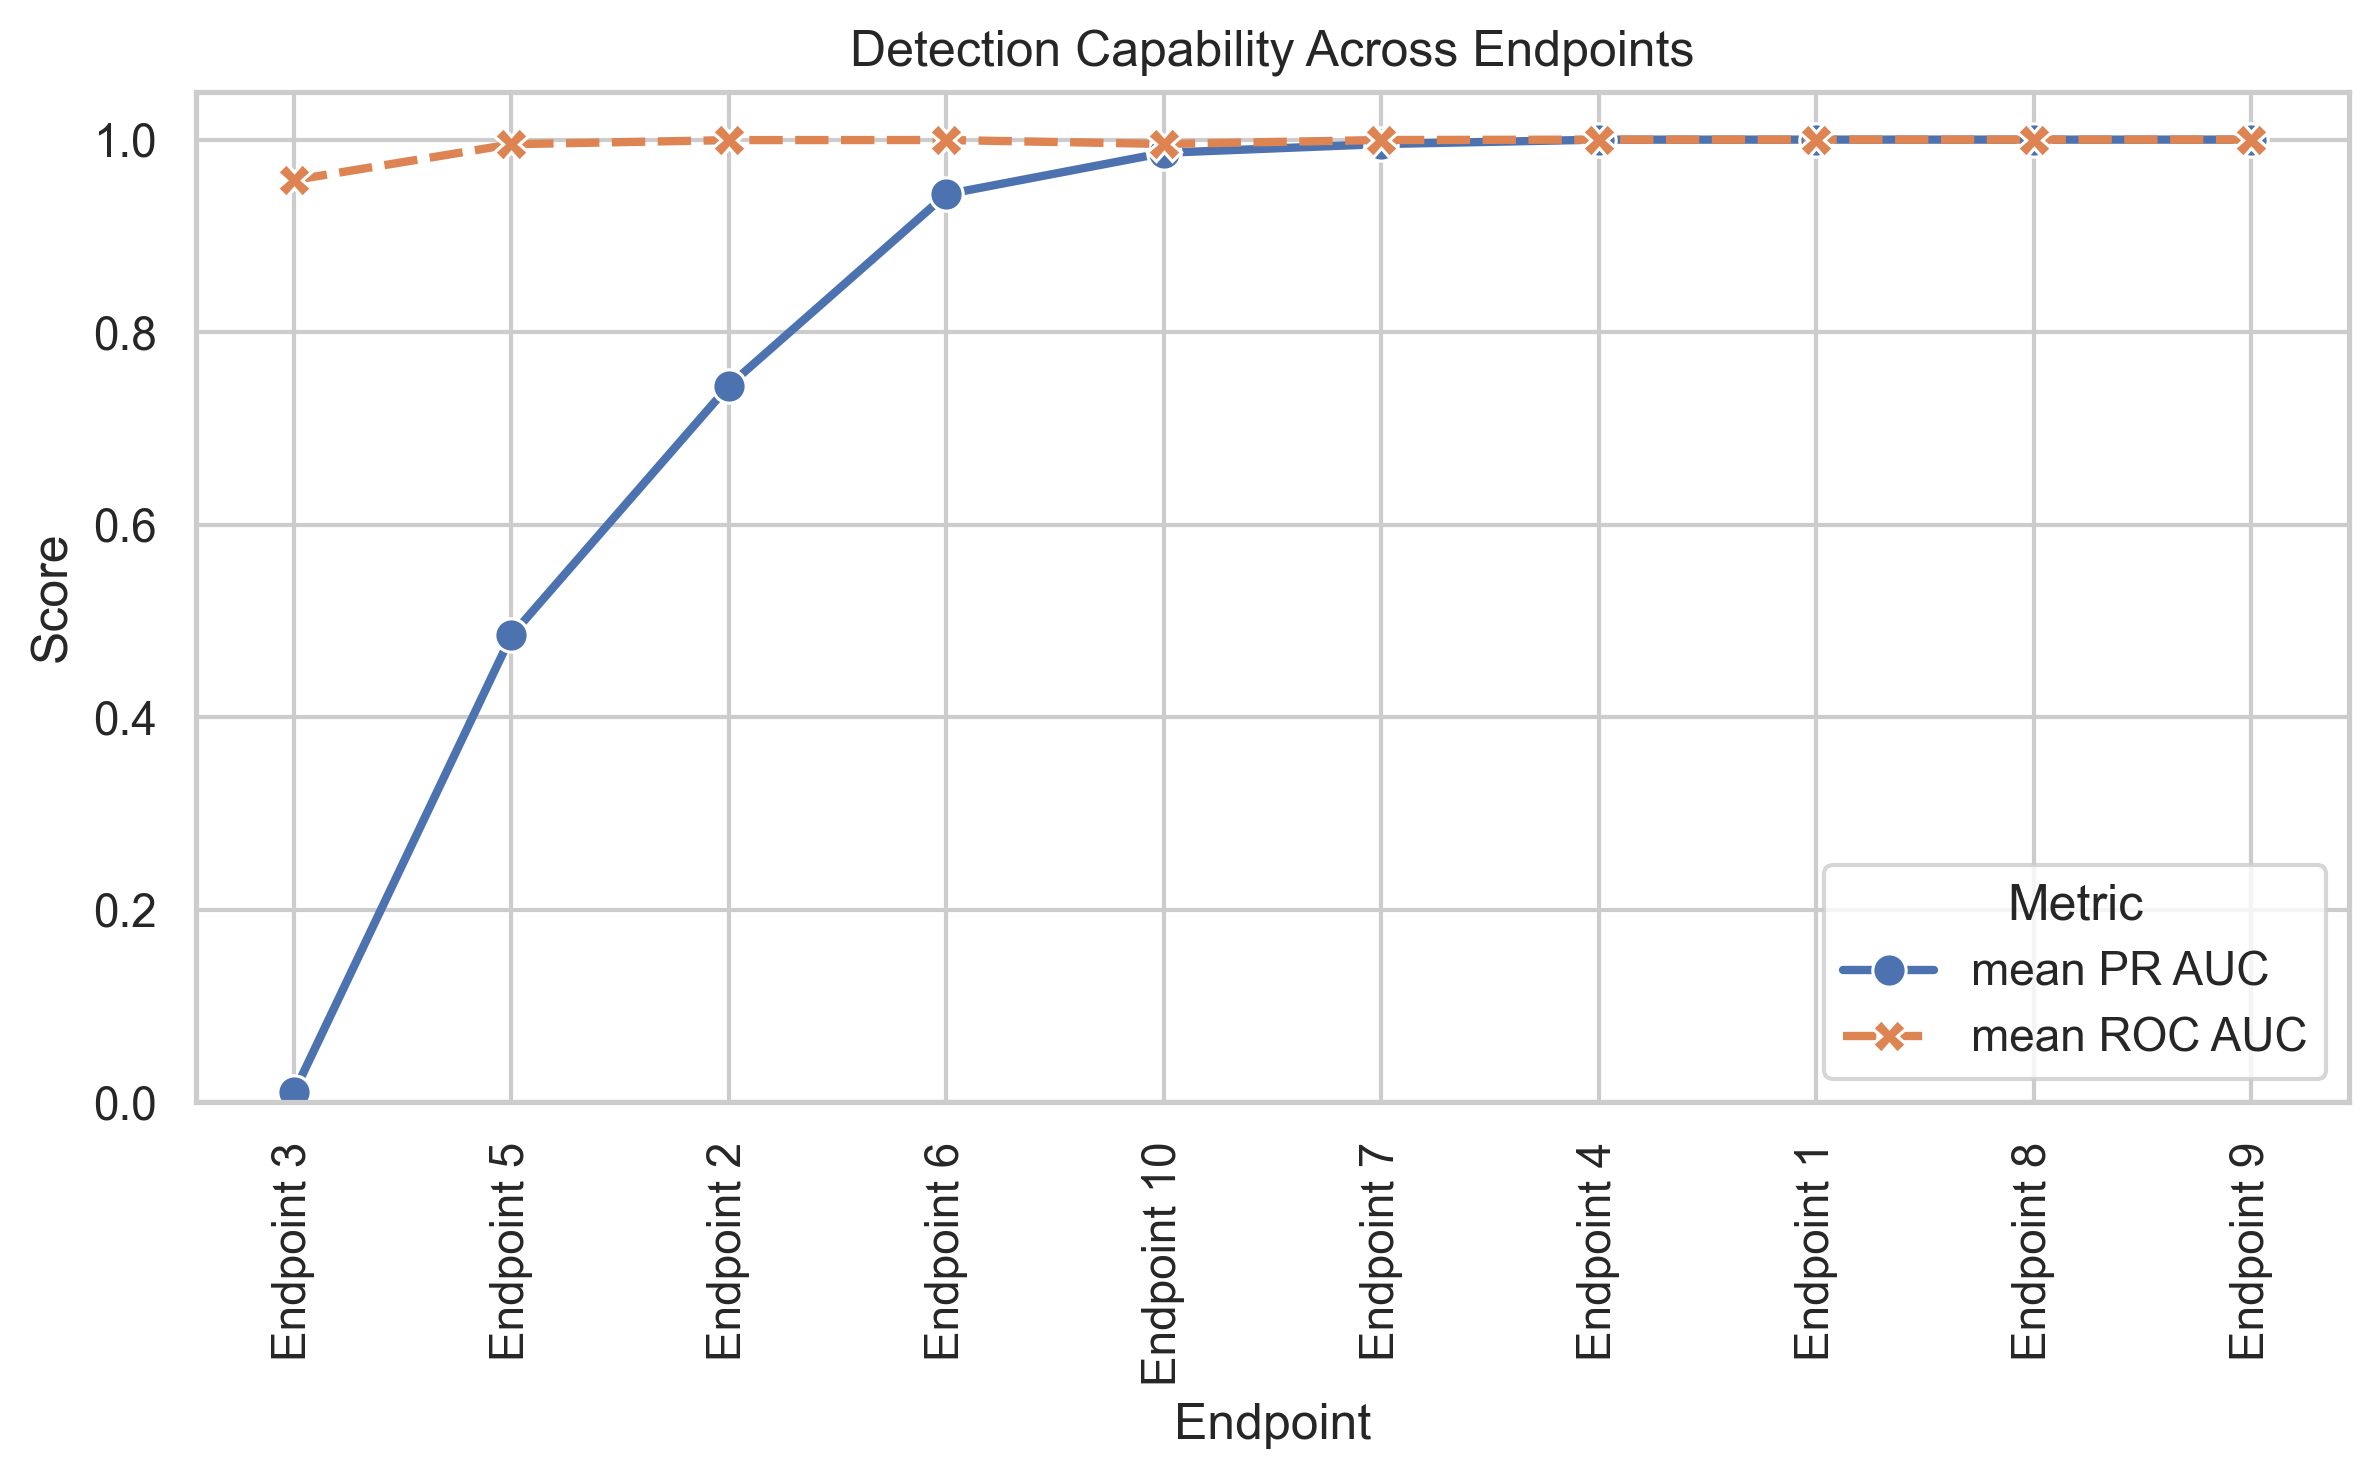

In [50]:
eta.plot_detection_capability(df_eta_metrics, figsize=(8, 5))

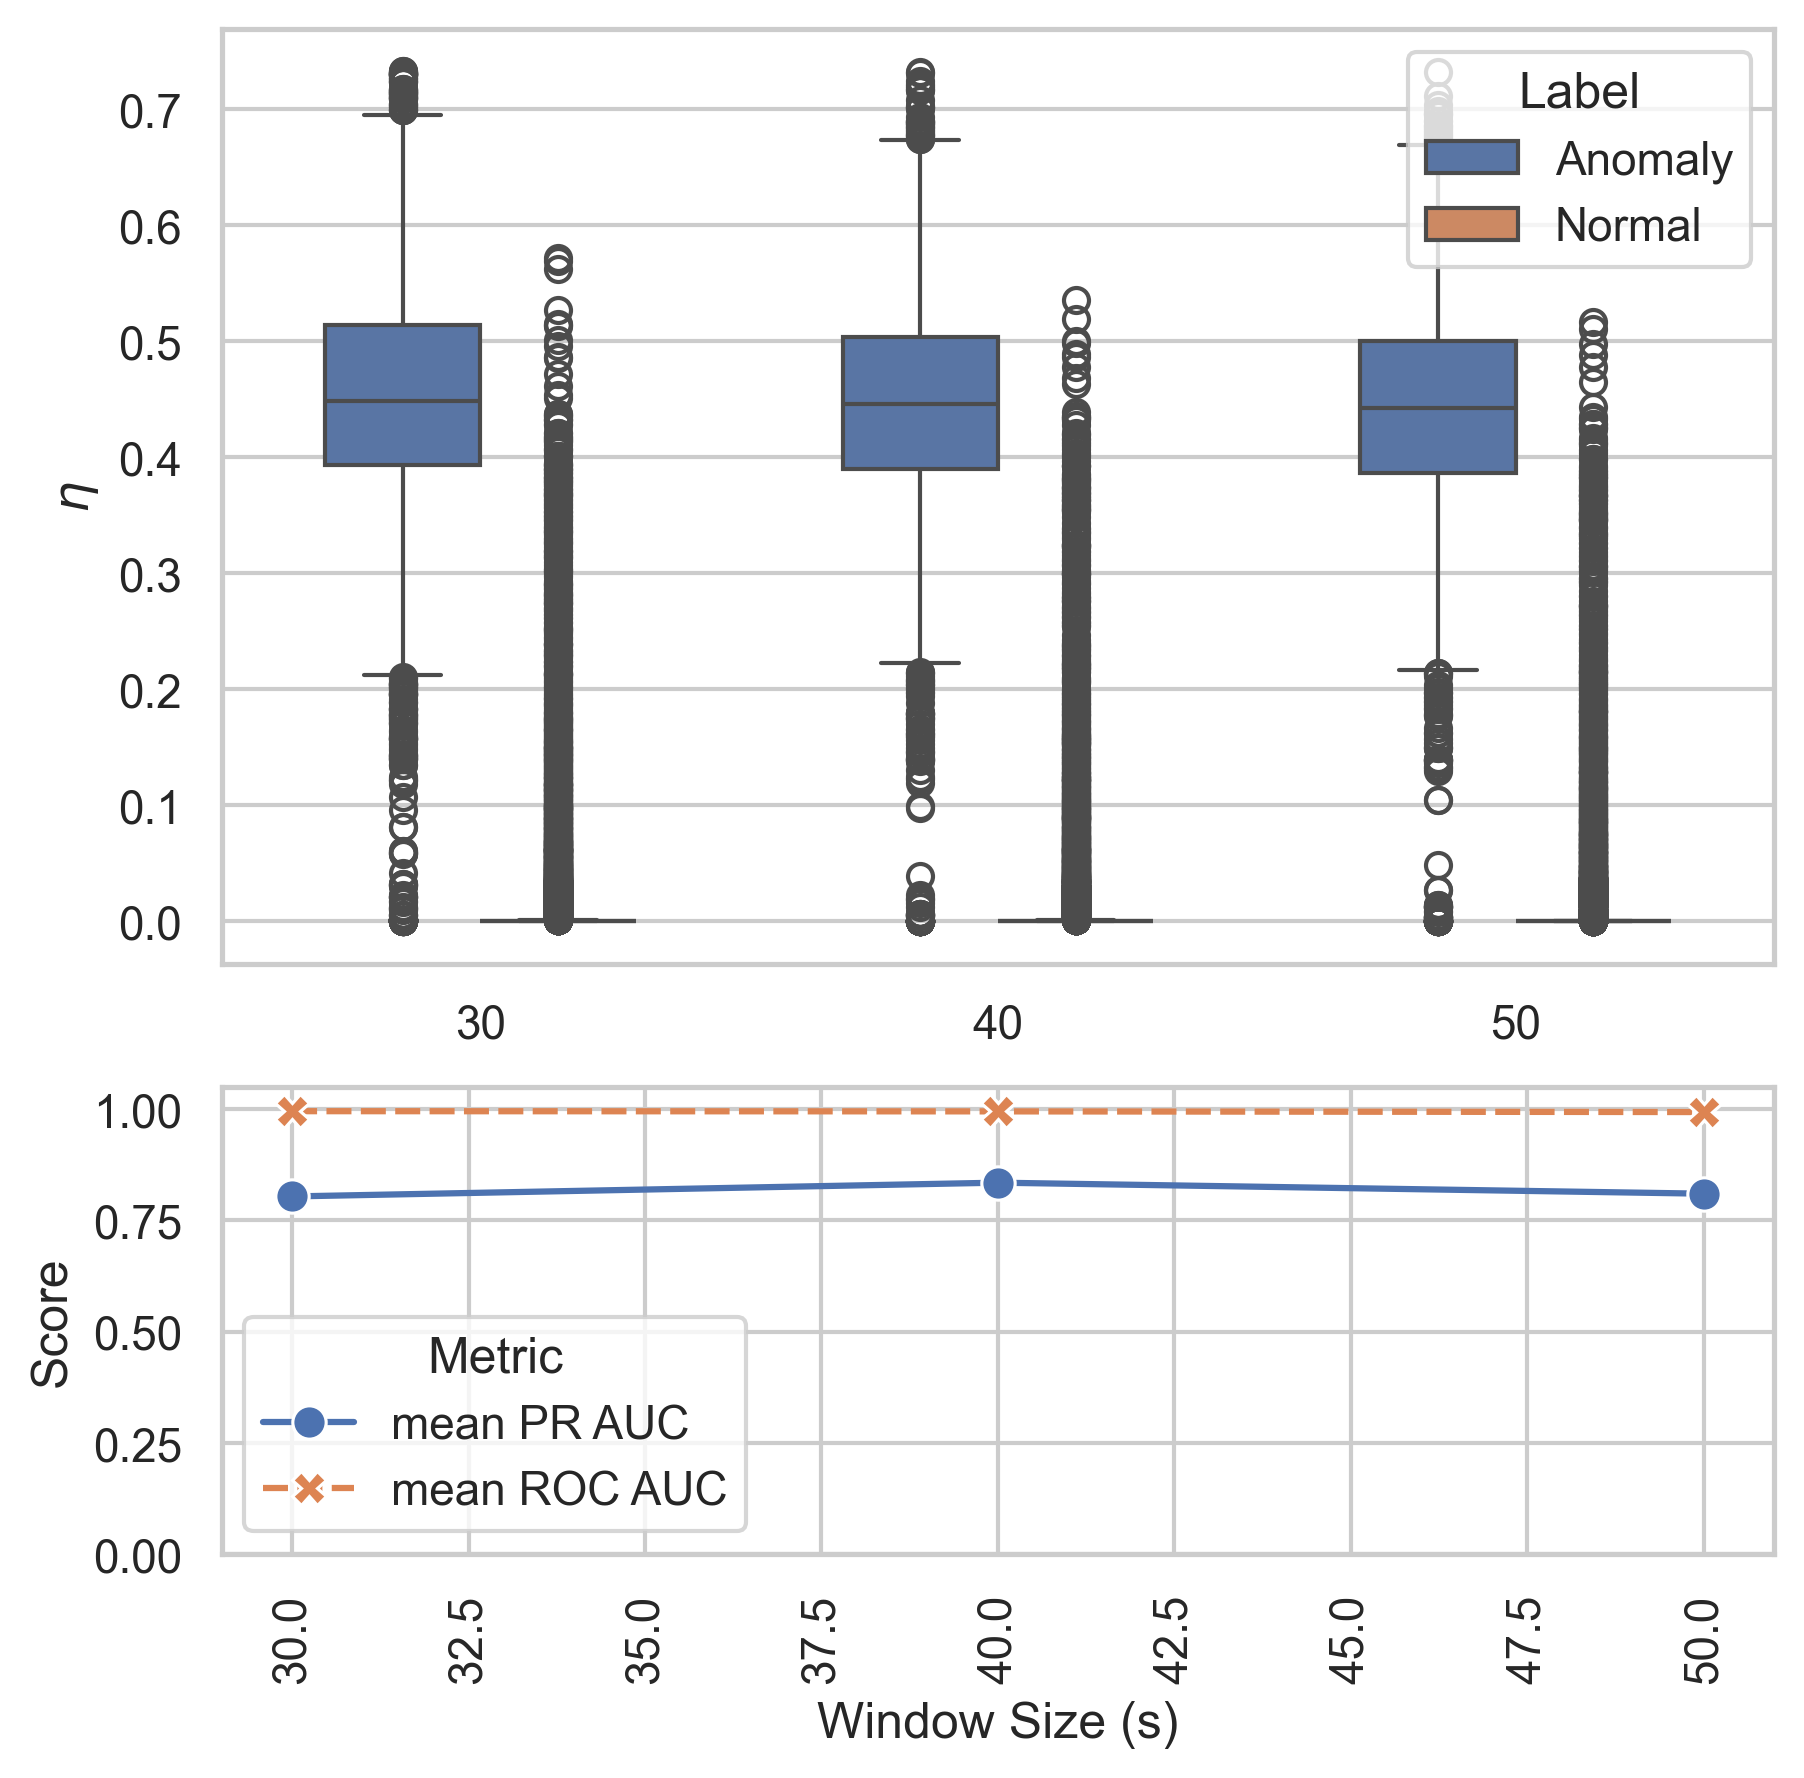

In [13]:
eta.plot_combined_analysis(df_eta_metrics, df_eta, figsize=(6, 6))

In [14]:
eta.get_summary_stats(df_eta_metrics)

,Mean,Std,Min,Max
ROC_AUC,0.994741,0.012709,0.951996,1.0
PR_AUC,0.816415,0.319150,0.008772,1.0


In [15]:
eta.get_summary_stats(df_eta_metrics, group_by=["window_size"])

window_size   ROC_AUC                             PR_AUC            \
                   mean       std       min  max      mean       std   
0          30  0.995549  0.011350  0.963442  1.0  0.804028  0.338831   
1          40  0.995103  0.012918  0.958585  1.0  0.834992  0.325184   
2          50  0.993571  0.014914  0.951996  1.0  0.810226  0.327196   

                  
        min  max  
0  0.008772  1.0  
1  0.010309  1.0  
2  0.011111  1.0

### Ra Evaluation

Sensitivity analysis was conducted by independently varying
the observation sensitivity parameter k, process noise Q,
and observation noise R, while fixing the temporal aggregation window
to 30 seconds.

A separate analysis was conducted to evaluate robustness across
different window sizes.


Measured properties:
- Sensibility: how Ra responds to anomaly
- Ratio: if Ra responds more anomalies bigger
- Memory: if Ra is integrating along the time
- Robust: if it is consistent for different values of k, Q, R

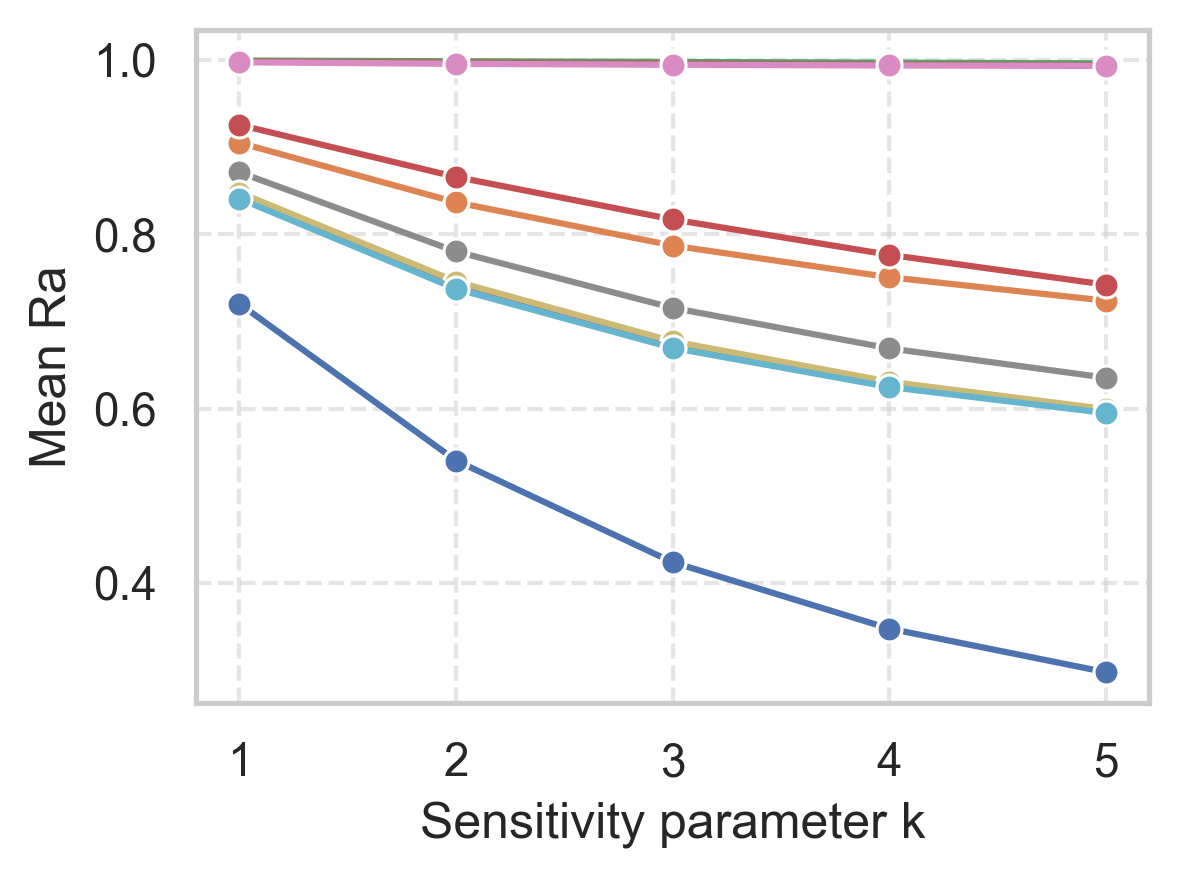

In [16]:
ra.plot_ra_vs_param_per_endpoint(df_k, "k")

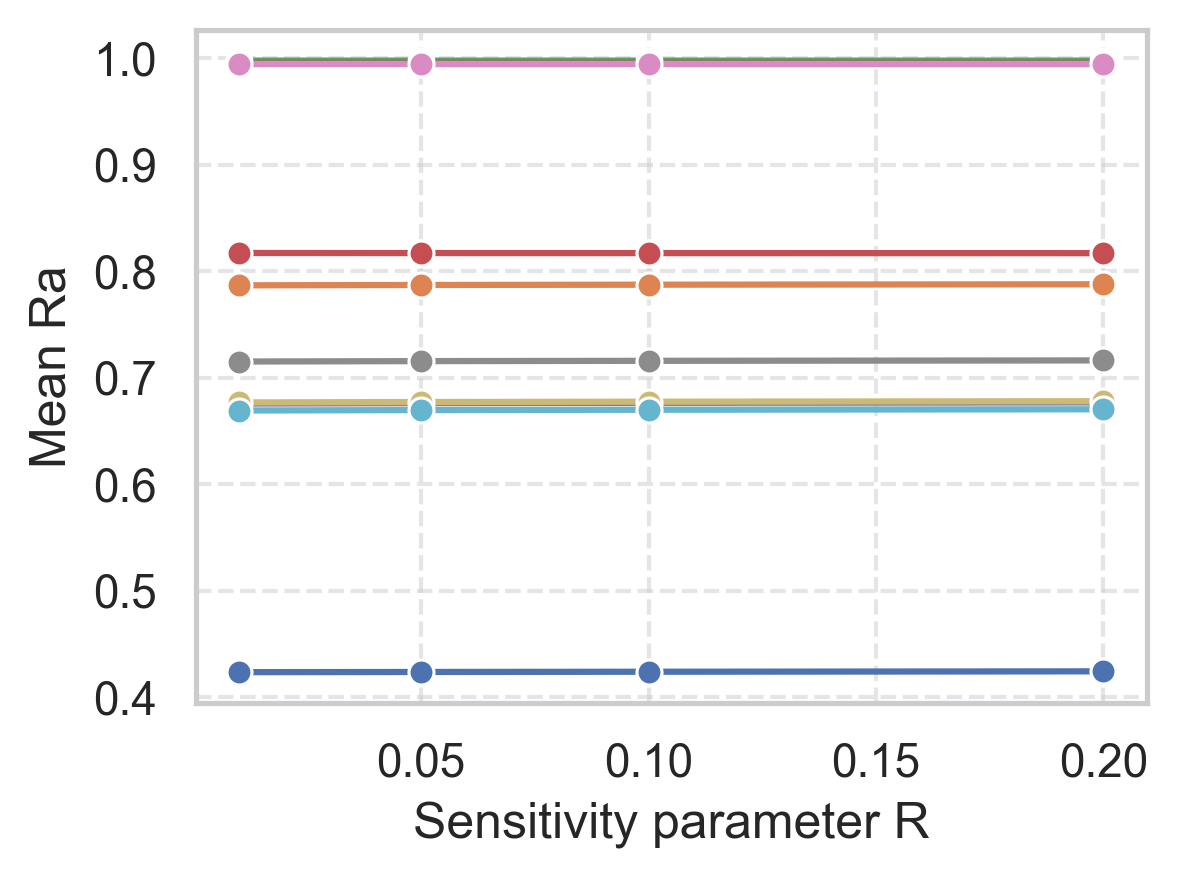

In [17]:
ra.plot_ra_vs_param_per_endpoint(df_r, "R")

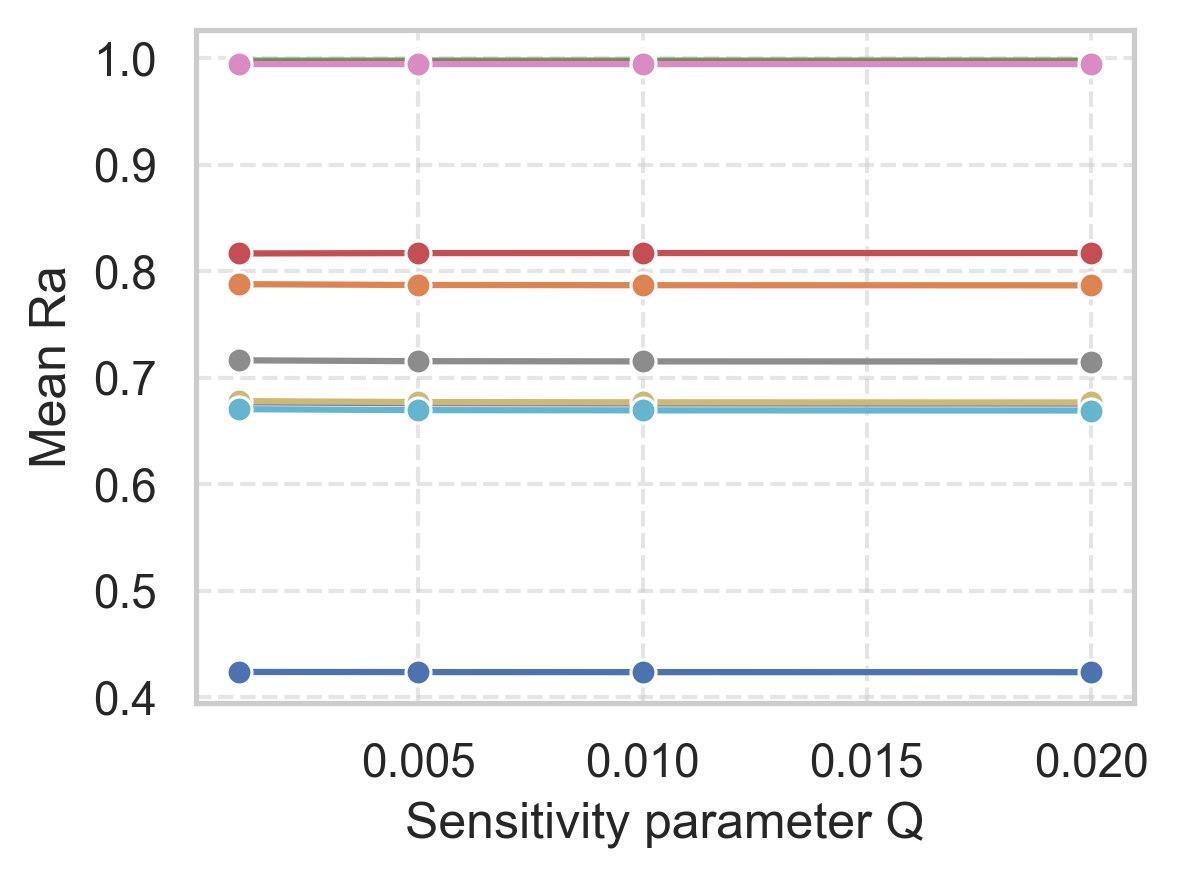

In [18]:
ra.plot_ra_vs_param_per_endpoint(df_q, "Q")

Ra in response to anomaly events

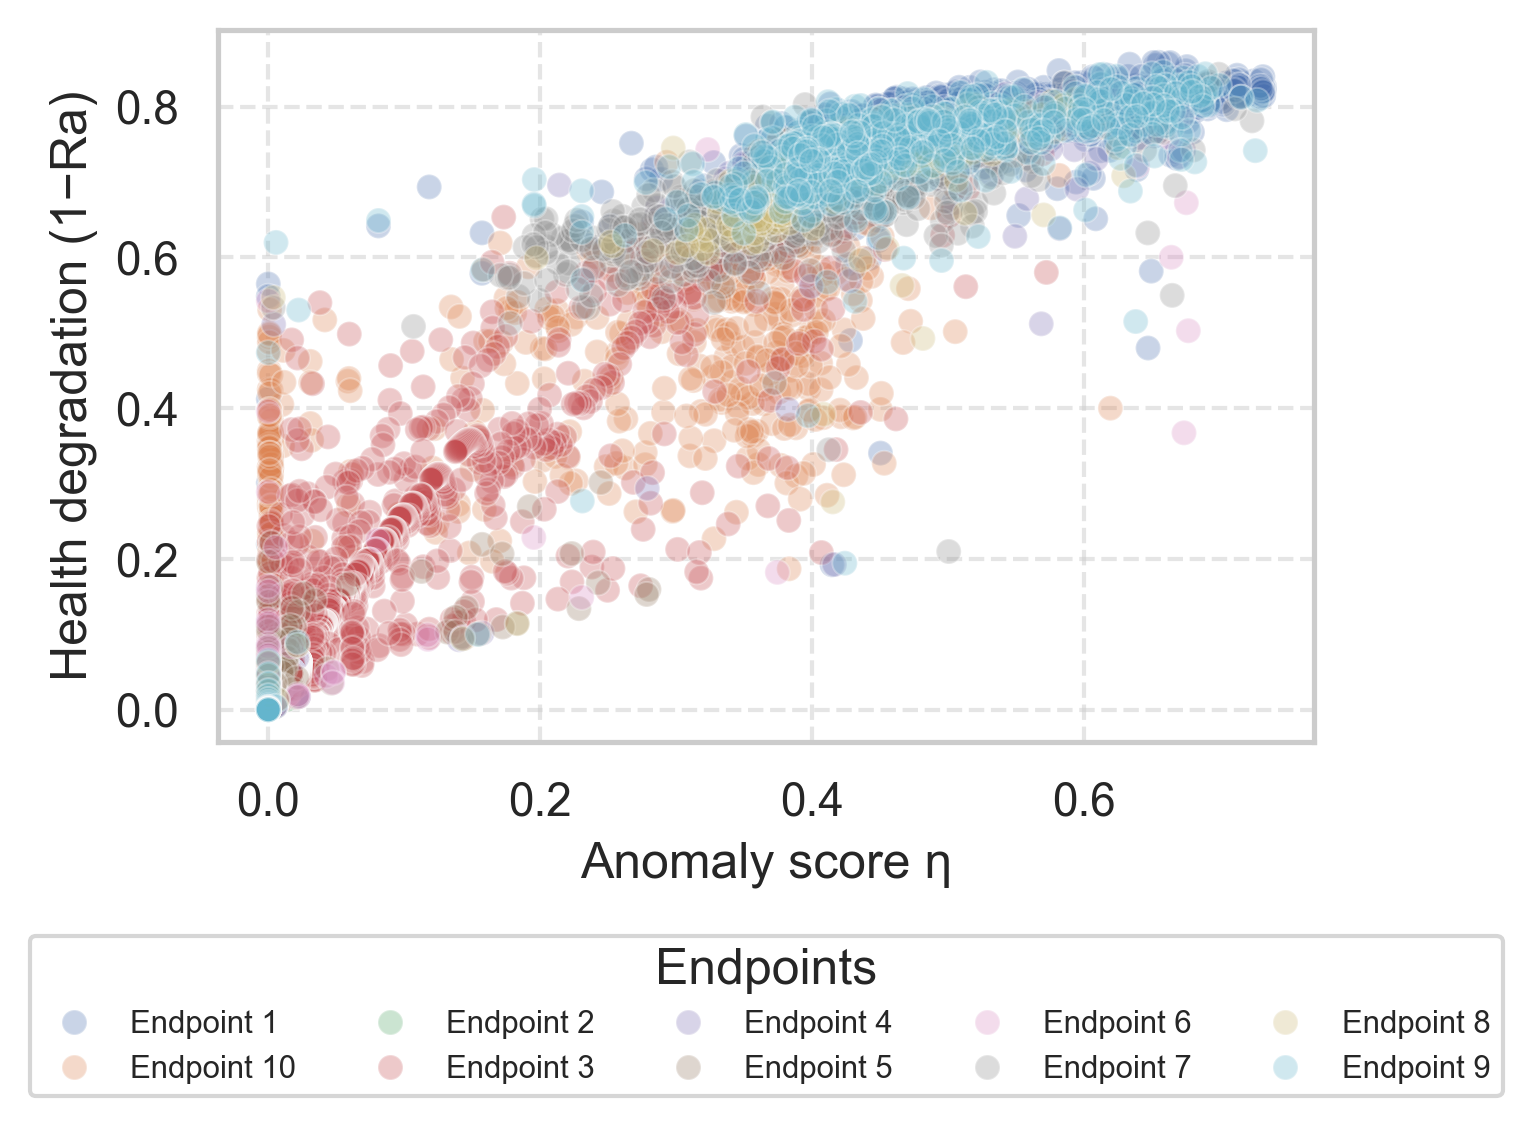

In [19]:
ra.plot_ra_vs_eta(df_ra_win[df_ra_win['window_size'] == 30])

In [68]:
def plot_ra_vs_eta_grid(
    df,
    col_wrap=5,
    height=1.8,
    save_path=None
):
    df = df.copy()
    df["degradation"] = 1 - df["Ra"]

    endpoints = sorted(
        df["endpoint"].unique(),
        key=lambda x: int(x.split()[-1])
    )

    colors = sns.color_palette("colorblind", len(endpoints))
    palette = dict(zip(endpoints, colors))

    sns.set_theme(
        style="whitegrid",
        context="paper",
        font="serif",
        rc={
            "font.size": 8,
            "axes.titlesize": 8,
            "axes.labelsize": 8,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7,
            "legend.fontsize": 7,
            "figure.dpi": 300,
            "axes.linewidth": 0.6,
            "grid.linewidth": 0.4,
        }
    )

    # --- criar grid ---
    g = sns.FacetGrid(
        df,
        col="endpoint",
        col_order=endpoints,
        hue="endpoint",
        palette=palette,
        col_wrap=col_wrap,
        height=height,
        aspect=1.1,
        sharex=True,
        sharey=True,
        despine=False
    )

    # --- scatter plot ---
    g.map_dataframe(
        sns.scatterplot,
        x="eta",
        y="degradation",
        alpha=0.6,
        s=8,
        linewidth=0
    )

    # --- labels ---
    g.set_axis_labels(
        "Anomaly score η",
        "Health degradation (1 − Ra)"
    )

    g.set_titles("{col_name}")

    # --- grid refinado ---
    for ax in g.axes.flat:
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

    plt.tight_layout(pad=0.3)

    # --- salvar (recomendado para paper) ---
    if save_path:
        plt.savefig(
            save_path,
            bbox_inches="tight",
            pad_inches=0.01
        )

    plt.show()

The endpoint-specific visualization confirms that the relationship between anomaly score and health degradation is consistent across all monitored services. While minor differences in degradation magnitude are observed due to endpoint-specific traffic dynamics and anomaly persistence, all endpoints exhibit the same monotonic functional response. This demonstrates that the proposed Kalman-based health indicator is robust and generalizable across heterogeneous traffic profiles.

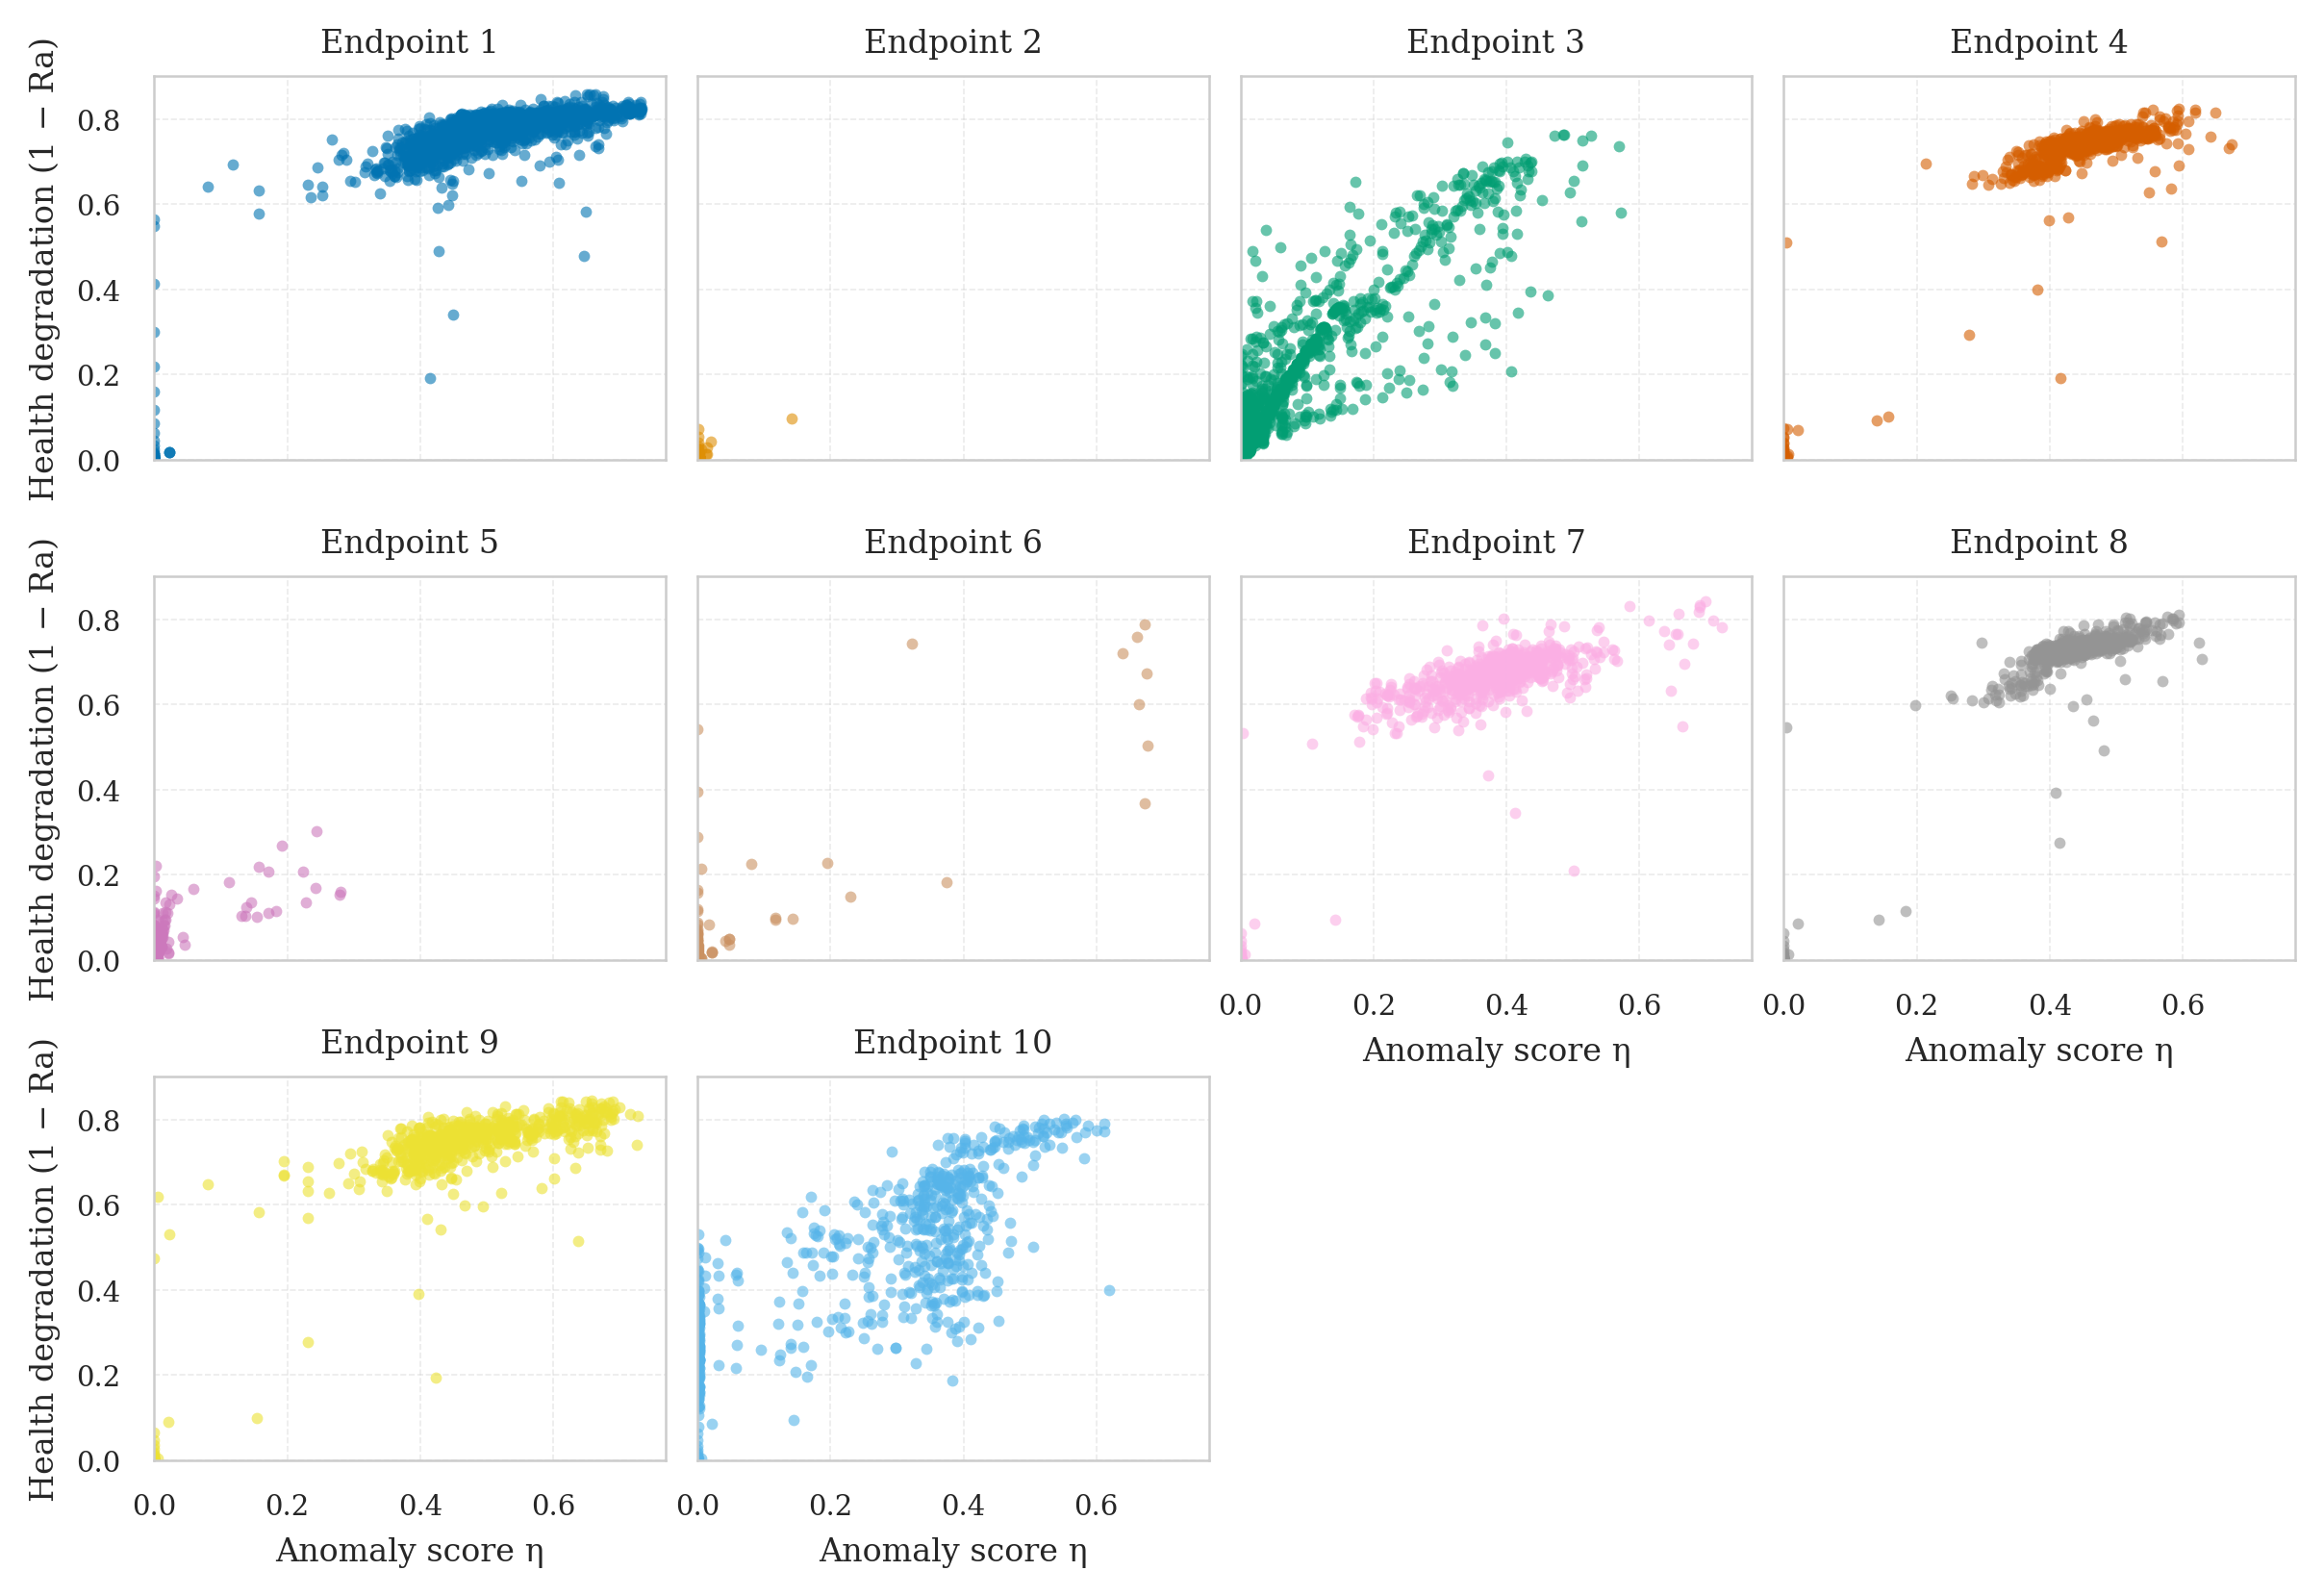

In [69]:
plot_ra_vs_eta_grid(df_ra_win[df_ra_win['window_size'] == 30], col_wrap=4)

Below, it is provided a anomaly event profile of each endpoint. The anomaly frequency column states the percentage of the windows where anomaly begins, mean duration windows shows for how many windows the events happends, and total events comprises events as whole.

The anomaly analysis reveals that anomalies are rare but highly persistent across most endpoints. While the anomaly frequency is on the order of 10⁻³ events per window, the average duration reaches hundreds of windows in several endpoints, corresponding to several hours of sustained degradation. This indicates that anomalies correspond to structural state changes rather than transient fluctuations. Furthermore, the grid analysis shows a consistent monotonic relationship between anomaly score and degradation, confirming that η reliably captures persistent degradation regimes. Endpoint 10 exhibits a different behavior, with more frequent but shorter anomalies, suggesting higher volatility rather than sustained degradation.

In [72]:
import pandas as pd

def build_anomaly_summary_table(df):
    """
    Builds a table with anomaly frequency and mean duration (in windows)
    for each endpoint.

    Uses column:
        has_anomaly (0/1)
        window_id (ordering)
    """

    results = []

    for endpoint, group in df.groupby("endpoint"):
        group = group.sort_values("window_id").copy()
        total_windows = len(group)

        # detectar início de eventos anômalos
        group["start"] = (
            (group["has_anomaly"] == 1) &
            (group["has_anomaly"].shift(1, fill_value=0) == 0)
        )

        # identificar eventos
        group["event_id"] = group["start"].cumsum()

        # manter apenas janelas anômalas
        anomaly_windows = group[group["has_anomaly"] == 1]

        if len(anomaly_windows) > 0:

            durations = (
                anomaly_windows
                .groupby("event_id")
                .size()
            )

            mean_duration = durations.mean()
            total_events = len(durations)

        else:
            mean_duration = 0.0
            total_events = 0

        frequency = total_events / total_windows

        results.append({
            "endpoint": endpoint,
            "anomaly_frequency": frequency,
            "mean_duration_windows": mean_duration,
            "total_events": total_events,
            "total_windows": total_windows
        })

    result = pd.DataFrame(results)

    # ordenar numericamente
    result = result.sort_values(
        "endpoint",
        key=lambda col: col.str.extract(r'(\d+)').astype(int)[0]
    )

    return result.reset_index(drop=True)

In [77]:
summary = build_anomaly_summary_table(df_ra_win[df_ra_win['window_size'] == 30])
summary

,endpoint,anomaly_frequency,mean_duration_windows,total_events,total_windows
0,Endpoint 1,0.000970,551.333333,3,3092
1,Endpoint 2,0.000647,1.000000,2,3092
2,Endpoint 3,0.000323,1.000000,1,3092
3,Endpoint 4,0.001940,104.000000,6,3092
4,Endpoint 5,0.000970,1.333333,3,3092
5,Endpoint 6,0.000647,5.500000,2,3092
6,Endpoint 7,0.001294,154.750000,4,3092
7,Endpoint 8,0.000970,207.000000,3,3092
8,Endpoint 9,0.000970,207.333333,3,3092
9,Endpoint 10,0.021992,8.000000,68,3092


In [25]:
events_k = ra.extract_event_impacts(df_k)
events_Q = ra.extract_event_impacts(df_q)
events_R = ra.extract_event_impacts(df_r)
events_window = ra.extract_event_impacts(df_ra_win)

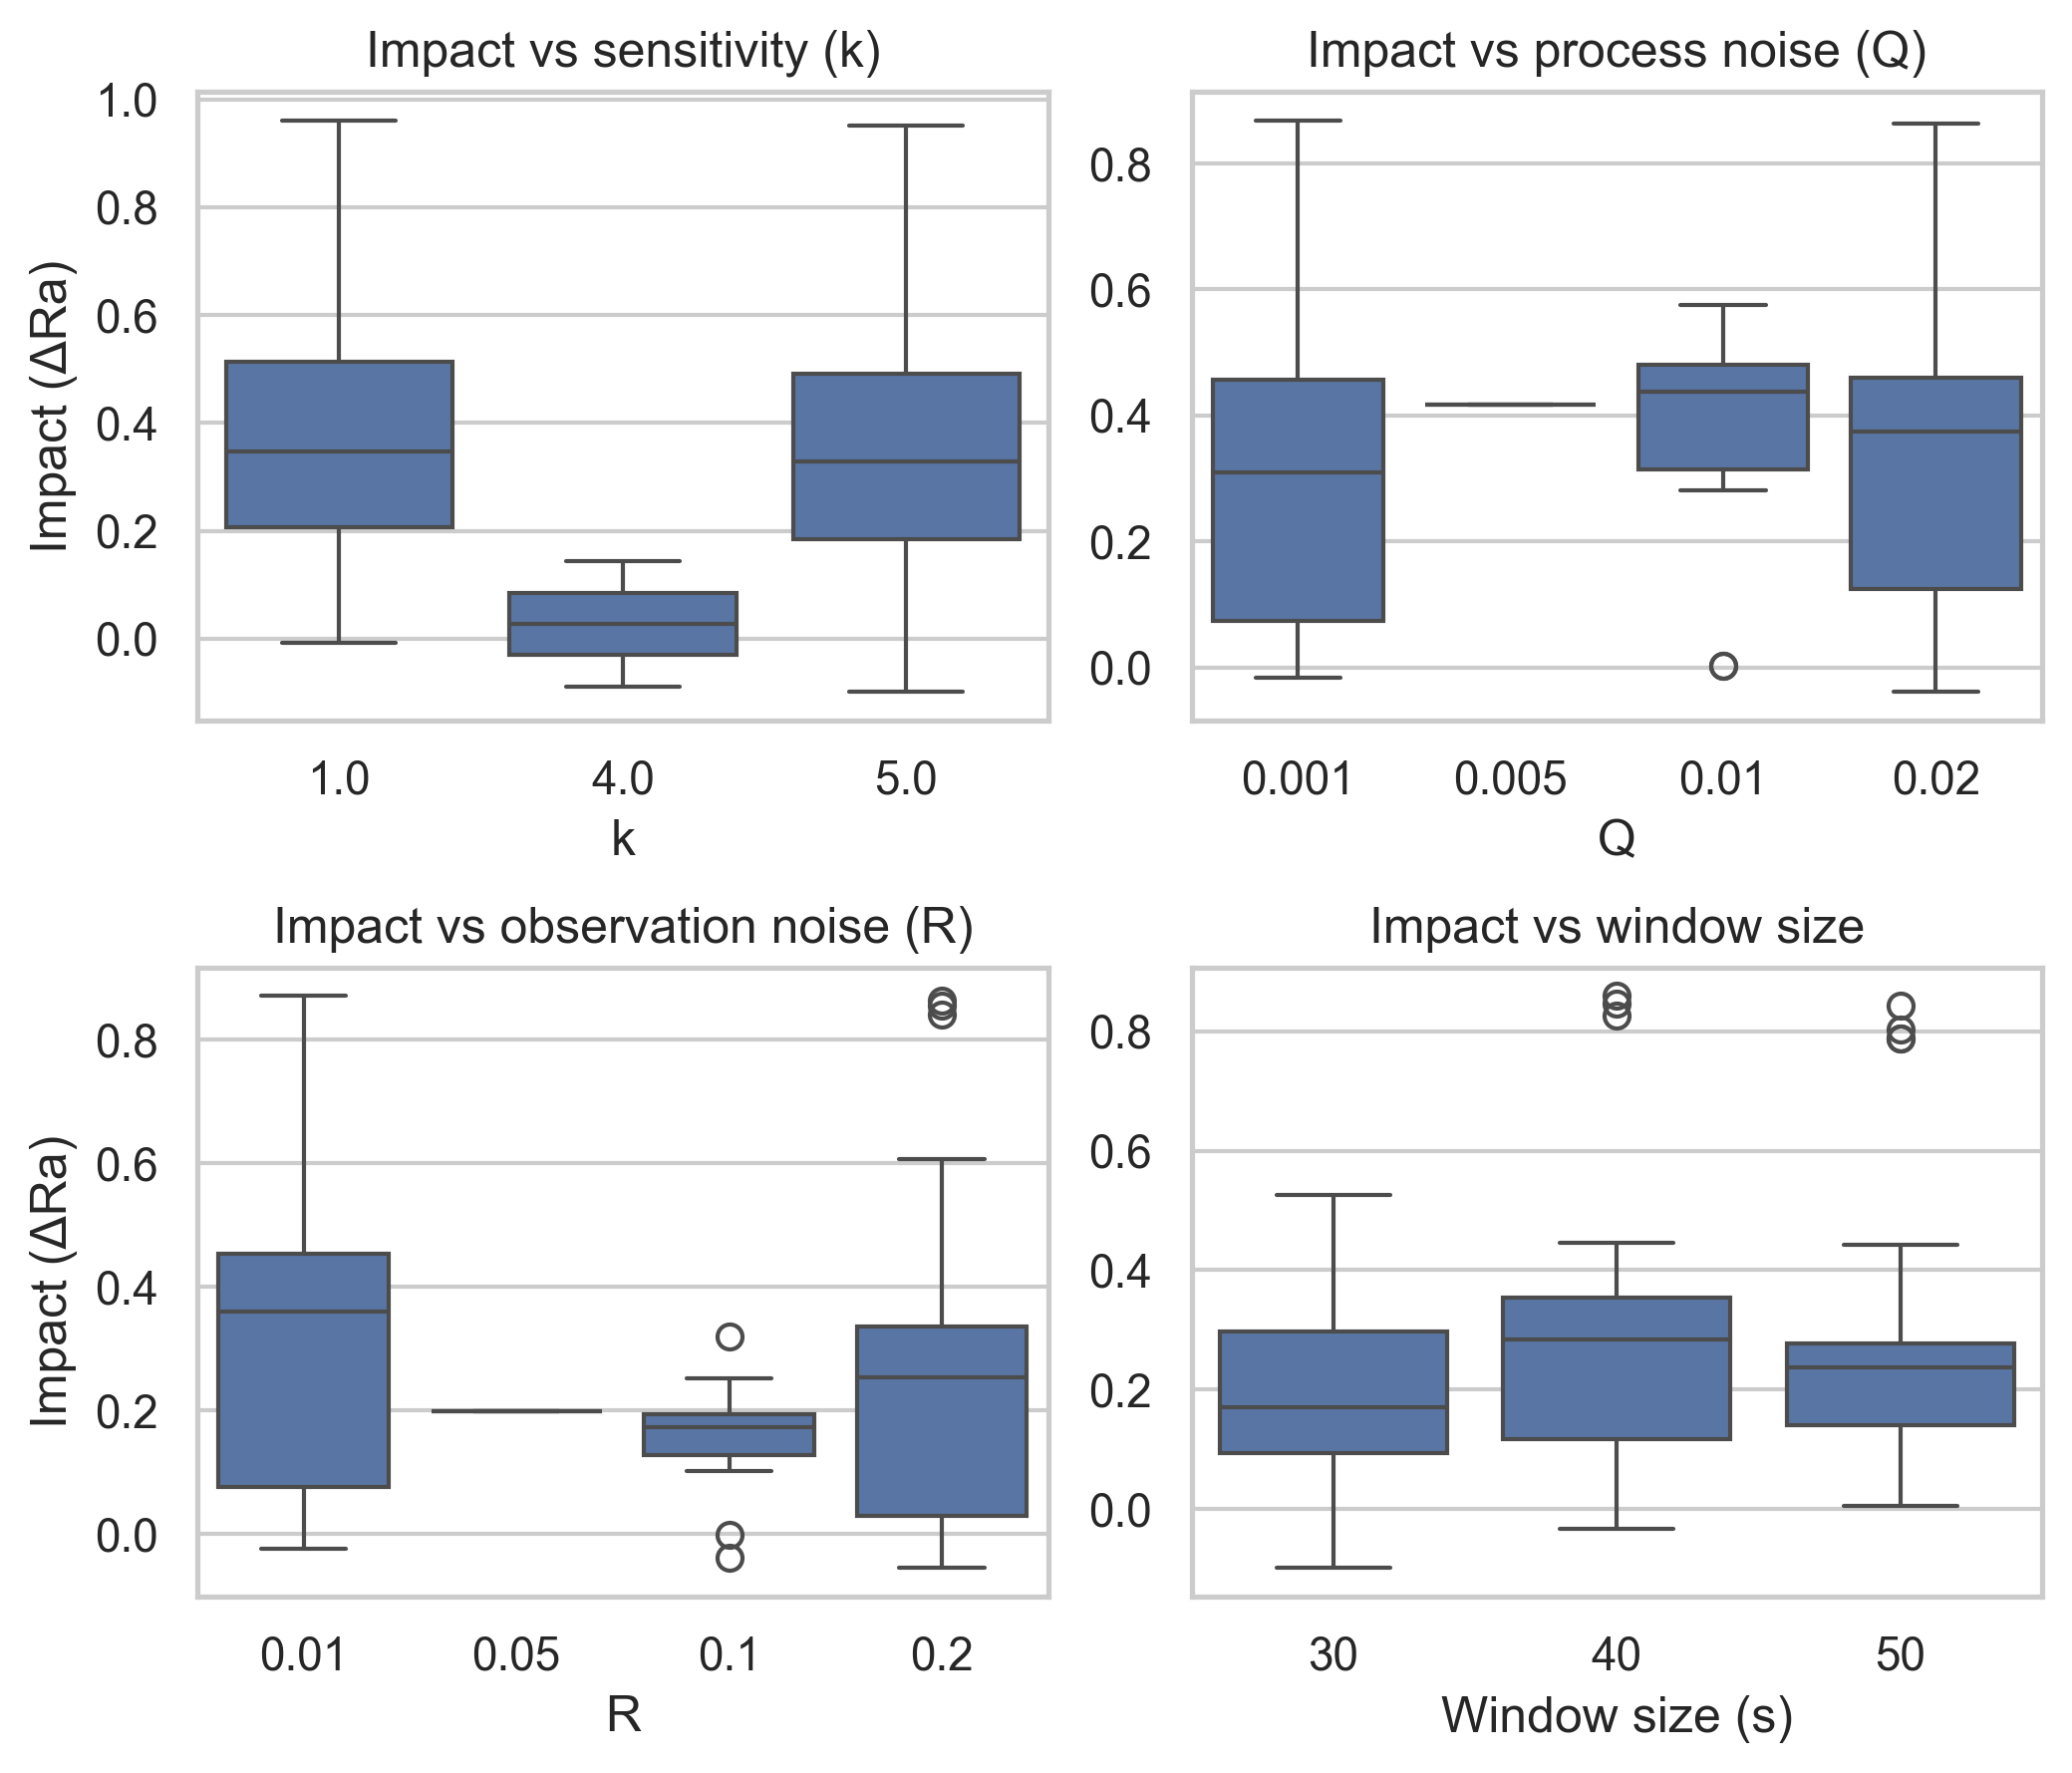

In [26]:
ra.plot_event_impact_grid(events_k, events_Q, events_R, events_window)

The results demonstrate that the Kalman-based health indicator exhibits stable behavior across a wide range of process and observation noise parameters, while allowing sensitivity tuning through the observation sensitivity parameter k. This confirms the robustness and interpretability of the proposed estimator.

In [27]:
summary_k = ra.build_summary_table(df_k, "k")
summary_k

,k,mean_Ra,std_Ra,mean_degradation,std_degradation
0,1.0,0.895206,0.147500,0.104794,0.147500
1,2.0,0.824178,0.244069,0.175822,0.244069
2,3.0,0.775412,0.308136,0.224588,0.308136
3,4.0,0.741463,0.351155,0.258537,0.351155
4,5.0,0.717467,0.380366,0.282533,0.380366


In [28]:
summary_q = ra.build_summary_table(df_q, "Q")
summary_q

,Q,mean_Ra,std_Ra,mean_degradation,std_degradation
0,0.001,0.775810,0.305770,0.224190,0.305770
1,0.005,0.775412,0.308136,0.224588,0.308136
2,0.010,0.775313,0.309066,0.224687,0.309066
3,0.020,0.775242,0.310015,0.224758,0.310015


In [29]:
summary_r = ra.build_summary_table(df_r, "R")
summary_r

,R,mean_Ra,std_Ra,mean_degradation,std_degradation
0,0.01,0.775213,0.310338,0.224787,0.310338
1,0.05,0.775412,0.308136,0.224588,0.308136
2,0.10,0.775572,0.307160,0.224428,0.307160
3,0.20,0.775809,0.306083,0.224191,0.306083


In [30]:
summary_window = ra.build_summary_table(df_ra_win, "window_size")
summary_window

,window_size,mean_Ra,std_Ra,mean_degradation,std_degradation
0,30,0.879180,0.260741,0.120820,0.260741
1,40,0.877346,0.260541,0.122654,0.260541
2,50,0.875583,0.260880,0.124417,0.260880


In [120]:
import pandas as pd

def build_event_summary(df,
                        time_col="window_start",
                        anomaly_col="has_anomaly",
                        Ra_col="Ra",
                        window_size_sec=30):

    data = df.copy()

    data[time_col] = pd.to_datetime(data[time_col])
    data = data.sort_values(["endpoint", time_col])

    summaries = []

    for endpoint, group in data.groupby("endpoint"):

        group = group.copy()

        group["start"] = (
            (group[anomaly_col] == 1) &
            (group[anomaly_col].shift(1, fill_value=0) == 0)
        )

        group["event_id"] = group["start"].cumsum()

        anomaly_windows = group[group[anomaly_col] == 1]

        if anomaly_windows.empty:
            continue

        durations = anomaly_windows.groupby("event_id").size()

        mean_duration = durations.mean()
        total_events = len(durations)
        total_windows = len(group)

        frequency = total_events / total_windows

        mean_Ra = anomaly_windows[Ra_col].mean()

        summaries.append({
            "endpoint": endpoint,
            "mean_duration": mean_duration,
            "frequency": frequency,
            "mean_Ra": mean_Ra,
            "degradation": 1 - mean_Ra,
            "total_events": total_events
        })

    return pd.DataFrame(summaries)

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import LogLocator, LogFormatterMathtext

def plot_ra_response_publication(summary_df,
                                 figsize=(3.5, 2.8),
                                 save_path=None):

    sns.set_theme(
        style="whitegrid",
        context="paper",
        font="serif",
        rc={
            "font.size": 8,
            "axes.labelsize": 8,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7
        }
    )

    fig, ax = plt.subplots(figsize=figsize)

    x = summary_df["mean_duration"].values
    y = summary_df["frequency"].values
    degradation = summary_df["degradation"].values

    # tamanho balanceado
    sizes = np.sqrt(summary_df["total_events"]) * 40

    scatter = ax.scatter(
        x,
        y,
        c=degradation,
        s=sizes,
        cmap="RdYlBu_r",   # melhor para severidade
        edgecolor="black",
        linewidth=0.5,
        alpha=0.9,
        zorder=3
    )

    # escala log
    ax.set_xscale("log")
    ax.set_yscale("log")

    # ticks log legíveis
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.yaxis.set_major_locator(LogLocator(base=10))

    ax.xaxis.set_major_formatter(LogFormatterMathtext())
    ax.yaxis.set_major_formatter(LogFormatterMathtext())

    # labels dos endpoints com fundo branco
    for _, row in summary_df.iterrows():

        label = row["endpoint"].split()[-1]

        ax.annotate(
            label,
            (row["mean_duration"], row["frequency"]),
            fontsize=7,
            weight="bold",
            ha="center",
            va="center",
            bbox=dict(
                facecolor="white",
                edgecolor="none",
                alpha=0.2,
                pad=0.8
            ),
            zorder=4
        )

    # colorbar melhorado
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Health degradation (1 − Ra)", fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    # labels
    ax.set_xlabel("Mean anomaly duration (windows)")
    ax.set_ylabel("Anomaly frequency")

    # grid refinado
    ax.grid(True, which="major", linestyle="--", alpha=0.4)
    ax.grid(True, which="minor", linestyle=":", alpha=0.2)

    sns.despine()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

Below, the chart shows the relationship between anomaly persistence and frequency across endpoints. Two distinct regimes emerge: persistent degradation, characterized by long anomaly durations and low frequency, and intermittent instability, characterized by short but frequent anomalies. Persistent regimes exhibit higher health degradation, confirming that sustained anomalies have a stronger impact on system health.

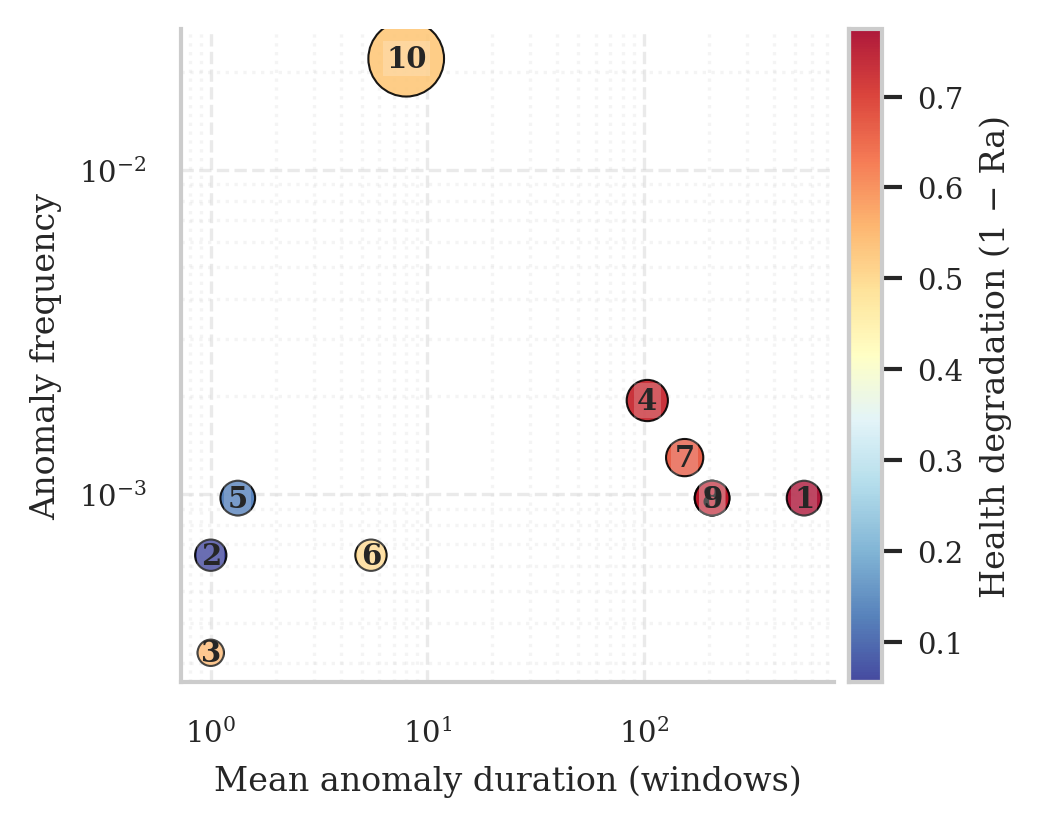

In [217]:
summary = build_event_summary(df_ra_win[df_ra_win['window_size'] == 30])

plot_ra_response_publication(summary)

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

def plot_ra_regimes_scatter(summary_df,
                                  figsize=(3.5, 2.8),
                                  save_path=None):

    sns.set_theme(
        style="whitegrid",
        context="paper",
        font="serif"
    )

    fig, ax = plt.subplots(figsize=figsize)

    norm = Normalize(
        vmin=summary_df["degradation"].min(),
        vmax=summary_df["degradation"].max()
    )

    scatter = ax.scatter(
        summary_df["mean_duration"],
        summary_df["frequency"],
        c=summary_df["degradation"],
        cmap="coolwarm",
        norm=norm,
        s=50,
        edgecolor="black",
        linewidth=0.6,
        zorder=3
    )

    ax.set_xscale("log")
    ax.set_yscale("log")

    # offset consistente em pontos (não em coordenadas de dados)
    for _, row in summary_df.iterrows():

        ep = row["endpoint"].split()[-1]

        ax.annotate(
            ep,
            xy=(row["mean_duration"], row["frequency"]),
            xytext=(5, 5),  # deslocamento fixo
            textcoords="offset points",
            fontsize=8,
            weight="bold",
            ha="left",
            va="bottom"
        )

    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Health degradation (1 − Ra)")

    ax.set_xlabel("Mean anomaly duration (windows)")
    ax.set_ylabel("Anomaly frequency")

    sns.despine()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [214]:
import plotly.graph_objects as go
import numpy as np
from scipy.spatial import ConvexHull

def plot_regimes_plotly_clean_with_labels_right(summary_df,
                                                distance_threshold=0.08,
                                                label_offset_factor=1.08):

    df = summary_df.copy()

    x = df["mean_duration"].values
    y = df["frequency"].values

    # escala correta tamanho
    desired_max_size = 40
    sizeref = 2. * df["total_events"].max() / (desired_max_size ** 2)

    fig = go.Figure()

    # ----------------------------
    # SCATTER PRINCIPAL
    # ----------------------------
    fig.add_trace(go.Scatter(

        x=x,
        y=y,

        mode="markers",

        marker=dict(

            size=df["total_events"],
            sizemode="area",
            sizeref=sizeref,
            sizemin=6,

            color=df["degradation"],
            colorscale="RdBu_r",

            line=dict(width=1, color="black"),

            colorbar=dict(
                title=dict(
                    text="Degradation (1−Ra)",
                    side="right",
                ),
                thickness=18,
                len=0.75
            )
        ),

        hovertemplate=
        "<b>%{text}</b><br>" +
        "Duration: %{x:.1f}<br>" +
        "Frequency: %{y:.5f}<br>" +
        "Events: %{marker.size}<br>" +
        "Degradation: %{marker.color:.3f}",

        text=df["endpoint"],

        showlegend=False
    ))

    # ----------------------------
    # AGRUPAR LABELS
    # ----------------------------
    log_x = np.log10(x)
    log_y = np.log10(y)

    used = set()
    label_x = []
    label_y = []
    label_text = []

    for i in range(len(df)):

        if i in used:
            continue

        group = [i]

        for j in range(i+1, len(df)):

            dist = np.sqrt(
                (log_x[i] - log_x[j])**2 +
                (log_y[i] - log_y[j])**2
            )

            if dist < distance_threshold:
                group.append(j)
                used.add(j)

        gx = np.mean(x[group])
        gy = np.mean(y[group])

        labels = [
            df.iloc[k]["endpoint"].split()[-1]
            for k in group
        ]

        label_x.append(gx * label_offset_factor)
        label_y.append(gy)
        label_text.append(",".join(labels))

    # ----------------------------
    # LABELS À DIREITA
    # ----------------------------
    fig.add_trace(go.Scatter(

        x=label_x,
        y=label_y,

        mode="text",

        text=label_text,

        textposition="middle left",

        textfont=dict(
            size=14,
            family="Serif",
            color="black"
        ),

        showlegend=False
    ))

    # ----------------------------
    # CLUSTERS (Convex Hull)
    # ----------------------------
    cluster_map = {

        "persistent": ["Endpoint 1","Endpoint 4","Endpoint 7","Endpoint 8","Endpoint 9"],

        "stable": ["Endpoint 2","Endpoint 3","Endpoint 5","Endpoint 6"],

        "frequent": ["Endpoint 10"]
    }

    for endpoints in cluster_map.values():

        sub = df[df["endpoint"].isin(endpoints)]

        if len(sub) < 3:
            continue

        pts = np.column_stack([sub["mean_duration"], sub["frequency"]])

        hull = ConvexHull(np.log10(pts))
        hull_pts = pts[hull.vertices]

        path = "M " + " L ".join(f"{px},{py}" for px,py in hull_pts) + " Z"

        fig.add_shape(

            type="path",
            path=path,

            xref="x",
            yref="y",

            line=dict(color="black", width=2),
            fillcolor="rgba(0,0,0,0.04)"
        )

    # ----------------------------
    # ESCALA LOG CORRETA DOS EIXOS
    # ----------------------------
    freq_ticks = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]

    fig.update_layout(

        template="simple_white",

        width=650,
        height=480,

        margin=dict(l=70, r=90, t=30, b=60),

        xaxis=dict(
            title="Mean anomaly duration (windows)",
            type="log",
            tickvals=[1, 10, 100, 1000],
            ticktext=["10⁰","10¹","10²","10³"]
        ),

        yaxis=dict(
            title="Anomaly frequency",
            type="log",
            tickvals=freq_ticks,
            ticktext=[f"{v:.0e}" for v in freq_ticks]
        ),

        font=dict(
            family="Serif",
            size=16
        )
    )

    fig.show()

In [215]:
plot_regimes_plotly_clean_with_labels_right(summary)

In [133]:
def plot_ra_regimes_heatmap(summary_df,
                            figsize=(3.5, 2.5),
                            save_path=None):

    import seaborn as sns
    import matplotlib.pyplot as plt

    df = summary_df.copy()

    df = df.set_index("endpoint")

    plot_df = df[[
        "mean_duration",
        "frequency",
        "degradation"
    ]]

    plot_df.columns = [
        "Duration",
        "Frequency",
        "Degradation"
    ]

    sns.set_theme(style="white", context="paper")

    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        plot_df,
        cmap="coolwarm",
        annot=True,
        fmt=".2g",
        linewidths=0.5,
        cbar_kws={"label": "Value"},
        ax=ax
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [135]:
#%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


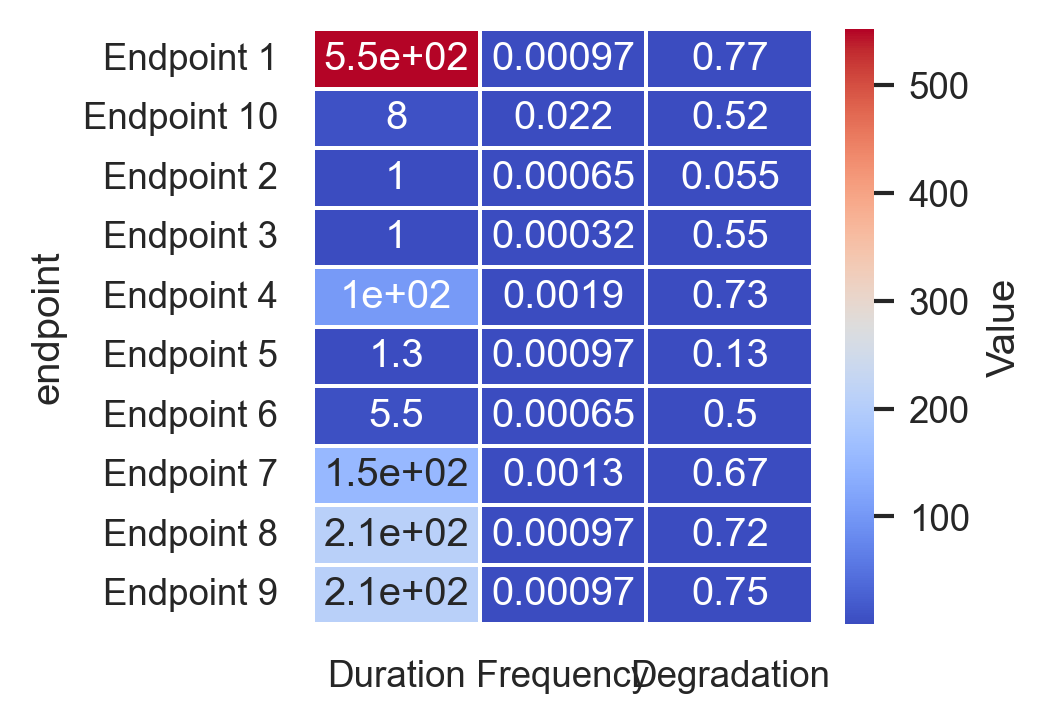

In [134]:
plot_ra_regimes_heatmap(summary)

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_classification_metrics_bar(
    metrics_df,
    window_size=50,
    figsize=(3.5, 2.6),
    subplot_label=None,
    save_path=None
):

    df = metrics_df.copy()
    df = df[df["window_size"] == window_size]

    endpoints = sorted(
        df["endpoint"].unique(),
        key=lambda x: int(x.split()[-1])
    )

    metrics = ["precision", "recall", "f1", "accuracy"]

    sns.set_theme(
        style="whitegrid",
        context="paper",
        font="serif",
        rc={
            "font.size": 8,
            "axes.labelsize": 8,
            "axes.titlesize": 9,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7,
            "legend.fontsize": 7,
            "axes.linewidth": 0.6,
        }
    )

    palette = {
        "precision": "#4C72B0",
        "recall": "#55A868",
        "f1": "#C44E52",
        "accuracy": "#8172B2"
    }

    fig, ax = plt.subplots(figsize=figsize)

    group_spacing = 1.6
    bar_width = 0.16

    x = np.arange(len(endpoints)) * group_spacing

    for i, metric in enumerate(metrics):

        values = [
            df[df["endpoint"] == ep][metric].values[0]
            for ep in endpoints
        ]

        offset = (i - 1.5) * bar_width

        linewidth = 1.0 if metric == "f1" else 0.4
        zorder = 3 if metric == "f1" else 2

        ax.bar(
            x + offset,
            values,
            width=bar_width,
            color=palette[metric],
            edgecolor="black",
            linewidth=linewidth,
            label=metric,
            zorder=zorder
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        endpoints,
        rotation=35,
        ha="right"
    )

    ax.set_ylabel("Metric value")

    # título IEEE correto
    ax.set_title(
        f"Window size = {window_size} s",
        fontsize=9,
        pad=4
    )

    ax.set_ylim(0, 1.05)

    ax.legend(
        ncol=4,
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.20),
        columnspacing=1.2,
        handlelength=1.8
    )

    if subplot_label is not None:
        ax.text(
            0.01,
            0.98,
            subplot_label,
            transform=ax.transAxes,
            fontsize=9,
            fontweight="bold",
            va="top"
        )

    sns.despine(ax=ax)

    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.grid(axis="x", visible=False)

    plt.tight_layout(pad=0.6)

    if save_path:
        plt.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()

In [108]:
ra_metrics = ra.compute_ra_classification_metrics(df_ra_win)

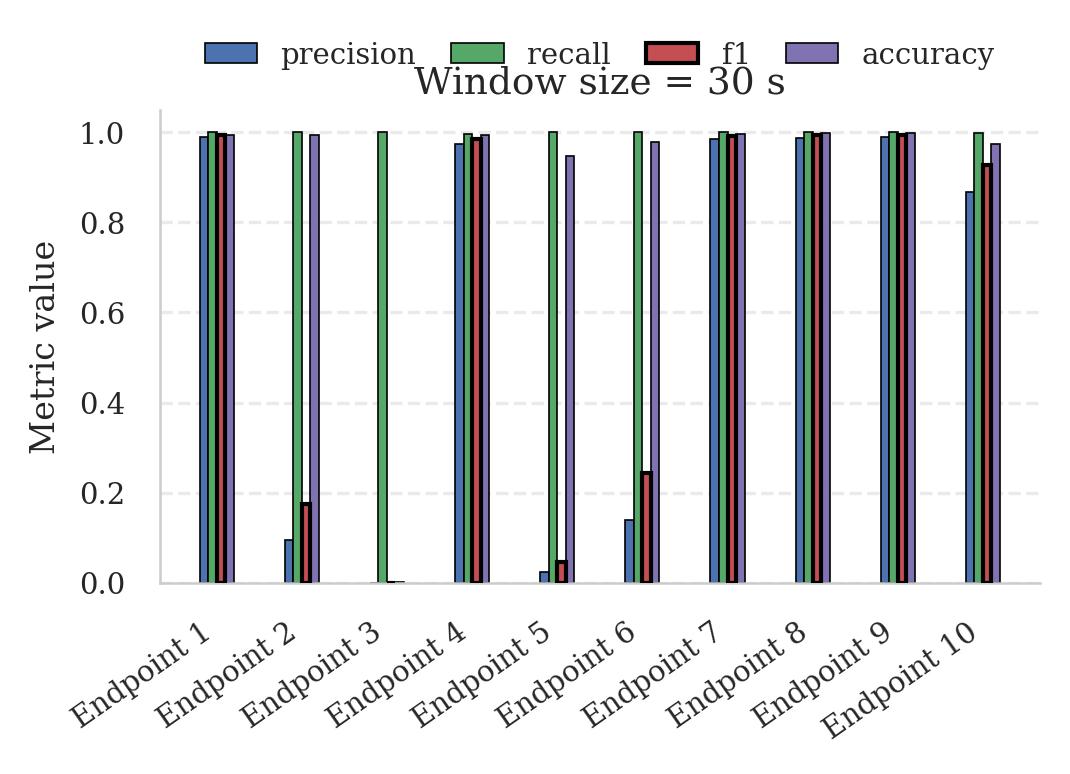

In [119]:
plot_classification_metrics_bar(ra_metrics, window_size=30)

group 1 - high precision and sensitiviy:
- Endpoint 1
- Endpoint 4
- Endpoint 7
- Endpoint 8
- Endpoint 9

characteristics:
- precision ≈ 0.97–0.99
- recall ≈ 1.0
- f1 ≈ 0.98–0.99
- accuracy ≈ 0.99–1.0

group 2 - high FP:
- Endpoint 2
- Endpoint 5
- Endpoint 6

characteristics:
- precision ≈ 0.02–0.14
- recall ≈ 1.0
- f1 ≈ 0.98–0.99

group 3 - outlier:
- Endpoint 3

group 4 - high variation:
- En

In [91]:
plot_results(3, df_ra_win[df_ra_win['window_size'] == 30], anomalous_traffic_win_observations_df[anomalous_traffic_win_observations_df['window_size'] == 30])

greatest anomaly at:2019-04-25 14:49:30 - begin plot:2019-04-25 14:39:30 - end plot:2019-04-25 15:19:30


greatest anomaly at:2019-04-24 18:16:00 - begin plot:2019-04-24 18:06:00 - end plot:2019-04-24 18:46:00


greatest anomaly at:2019-04-25 15:05:30 - begin plot:2019-04-25 14:55:30 - end plot:2019-04-25 15:35:30


In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_anomaly_timeline_seaborn(
    res_df,
    time_col="window_start",
    window_size_sec=30,
    figsize=(10, 4),
    save_path=None
):
    """
    Plots anomaly regime timeline using matplotlib/seaborn.
    Each anomaly event is shown as a horizontal bar.
    """

    df = res_df.copy()

    df[time_col] = pd.to_datetime(df[time_col])
    df["has_anomaly"] = df["has_anomaly"].astype(int)

    df = df.sort_values(["endpoint", time_col])

    # ordenar numericamente
    endpoints = sorted(
        df["endpoint"].unique(),
        key=lambda x: int(x.split()[-1])
    )

    # estilo IEEE
    sns.set_theme(
        style="whitegrid",
        context="paper",
        font="serif",
        rc={
            "font.size": 8,
            "axes.labelsize": 8,
            "axes.titlesize": 9,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7
        }
    )

    fig, ax = plt.subplots(figsize=figsize)

    y_positions = {endpoint: i for i, endpoint in enumerate(endpoints)}

    total_blocks = 0

    for endpoint in endpoints:

        sub = df[df["endpoint"] == endpoint].copy()

        # detectar eventos
        sub["start"] = (
            (sub["has_anomaly"] == 1) &
            (sub["has_anomaly"].shift(1, fill_value=0) == 0)
        )

        sub["event_id"] = sub["start"].cumsum()

        events = sub[sub["has_anomaly"] == 1].groupby("event_id")

        y = y_positions[endpoint]

        for _, event in events:

            start = event[time_col].iloc[0]
            end = event[time_col].iloc[-1] + pd.Timedelta(seconds=window_size_sec)

            ax.barh(
                y=y,
                width=end - start,
                left=start,
                height=0.6,
                color="red",
                edgecolor="black",
                linewidth=0.3
            )

            total_blocks += 1

    # configurar eixo Y
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(list(y_positions.keys()))

    ax.set_xlabel("Time")
    ax.set_ylabel("Endpoint")
    ax.set_title("Persistent anomaly regimes across endpoints")

    sns.despine()

    plt.tight_layout()

    if save_path:
        plt.savefig(
            save_path,
            bbox_inches="tight"
        )

    plt.show()

    print(f"Rendered {total_blocks} anomaly blocks")

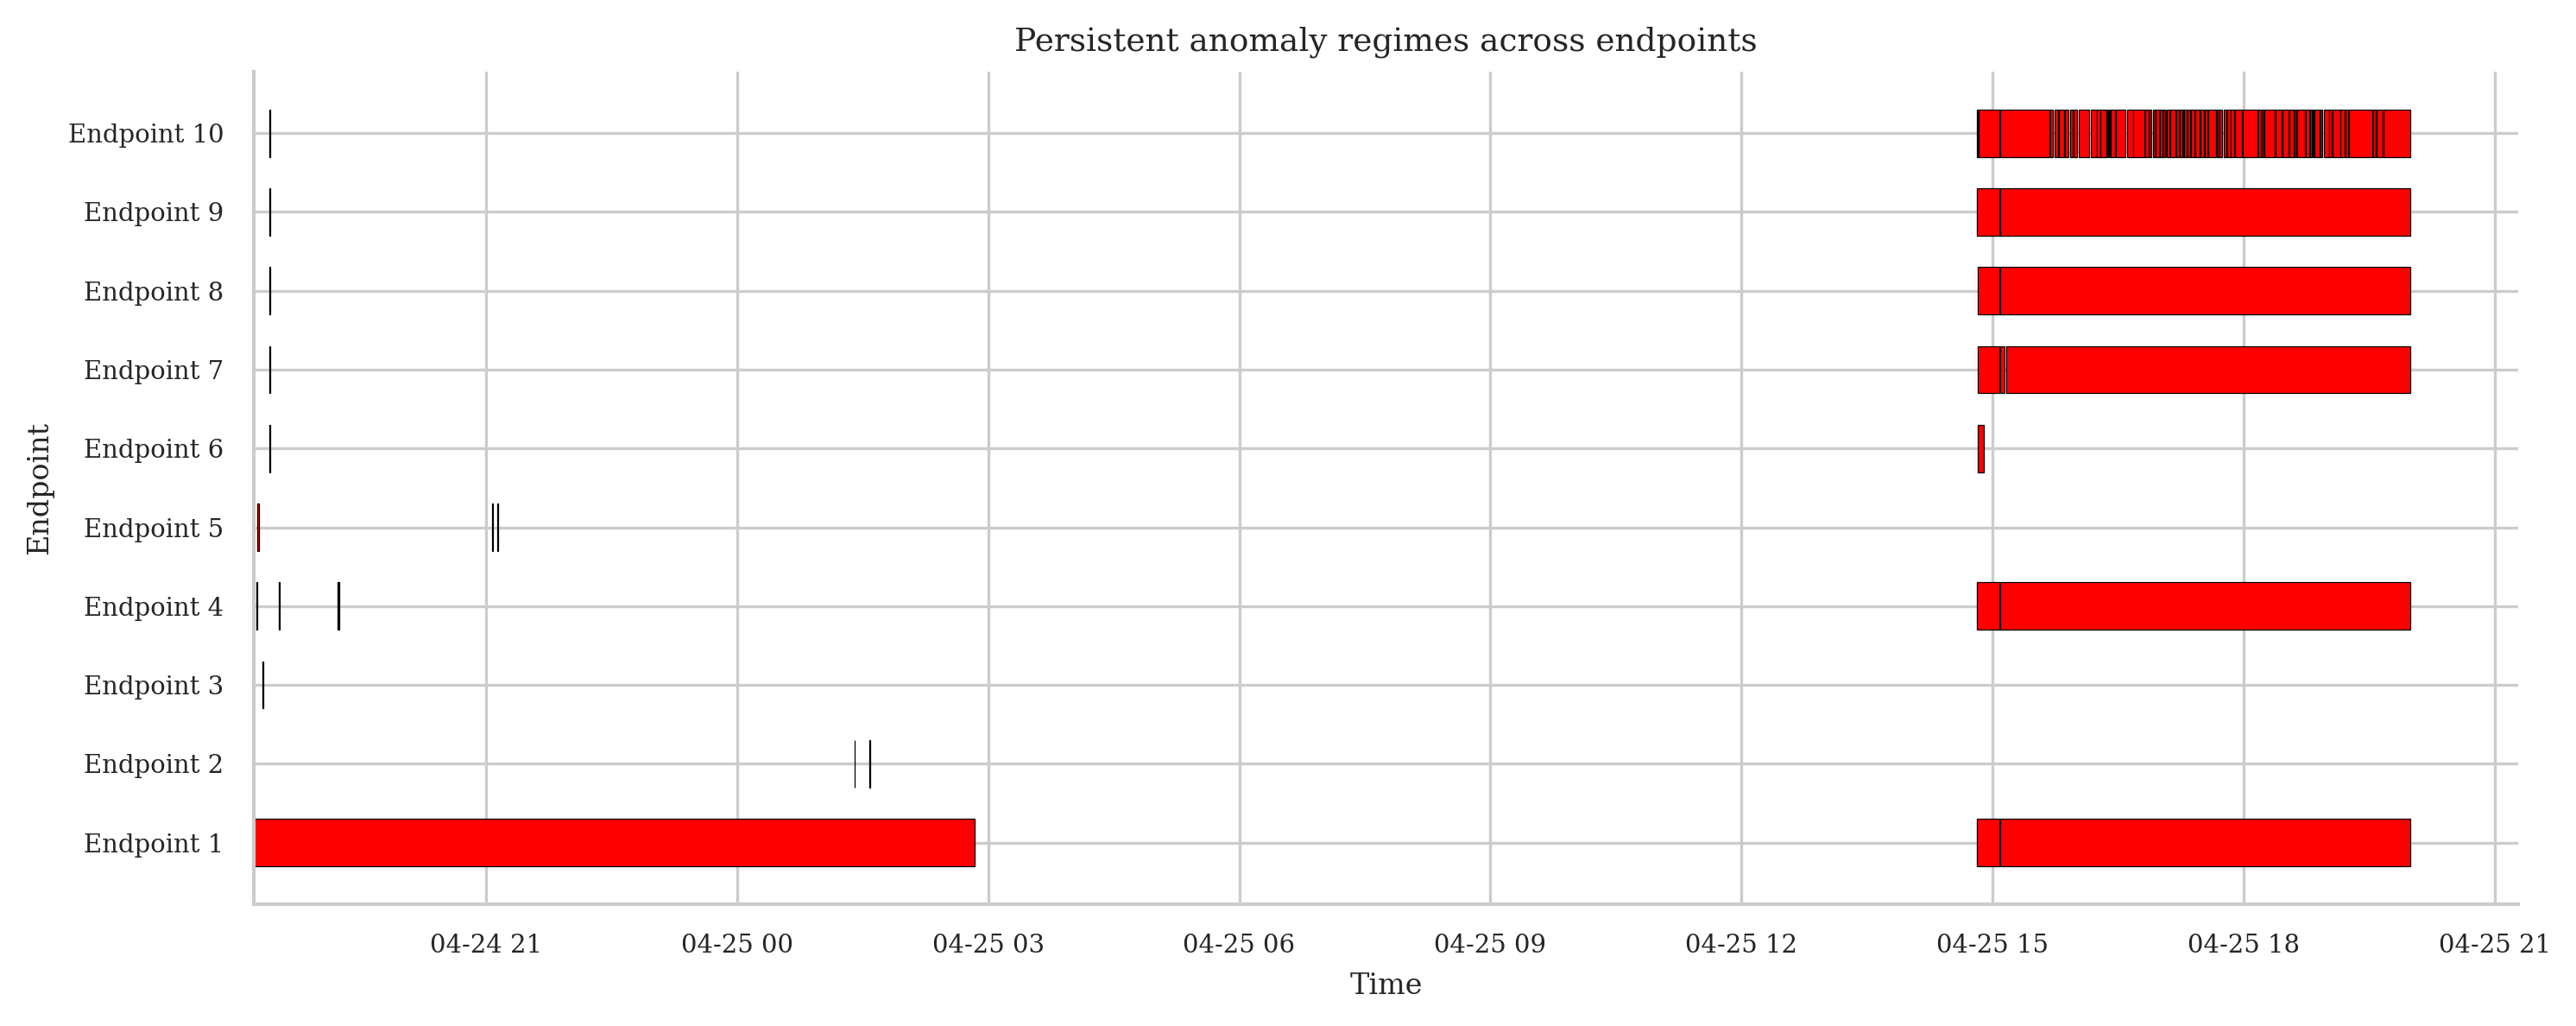

Rendered 95 anomaly blocks


In [87]:
plot_anomaly_timeline_seaborn(df_ra_win[df_ra_win['window_size'] == 30])